In [1]:
"""

This file reads the compact dataframes from the input databases and produces a series of plots which show some information on the dataframe entries. 
This can be checked for sanity against the original publication.

Author: Lucie Luecke
Date produced: 18/11/2024

Input: 
reads dataframe with the following keys:
['archiveType', 'climateInterpretation_variable', 'climateInterpretation_variableDetail',
 'dataSetName', 'geo_meanElev', 'geo_meanLat', 'geo_meanLon', 
 'originalDataURL', 'paleoData_TSid', 'paleoData_notes', 'paleoData_proxy', 
 'paleoData_units', 'paleoData_values', 'paleoData_variableName', 'year', 'yearUnits', (optional: 'DuplicateDetails')]

modify directory and filename (currently reads pickle) as needed
"""

"\n\nThis file reads the compact dataframes from the input databases and produces a series of plots which show some information on the dataframe entries. \nThis can be checked for sanity against the original publication.\n\nAuthor: Lucie Luecke\nDate produced: 18/11/2024\n\nInput: \nreads dataframe with the following keys:\n['archiveType', 'climateInterpretation_variable', 'climateInterpretation_variableDetail',\n 'dataSetName', 'geo_meanElev', 'geo_meanLat', 'geo_meanLon', \n 'originalDataURL', 'paleoData_TSid', 'paleoData_notes', 'paleoData_proxy', \n 'paleoData_units', 'paleoData_values', 'paleoData_variableName', 'year', 'yearUnits', (optional: 'DuplicateDetails')]\n\nmodify directory and filename (currently reads pickle) as needed\n"

# Set up working environment

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from matplotlib.gridspec import GridSpec as GS
from copy import deepcopy as dc

In [3]:
# set up working directory. 
# The default working directory should be the parent folder (compile_proxy_database) so we can access the 'helper' files 
# Make sure this is changing to the correct path!

#wdir = '/home/jupyter-lluecke/compile_proxy_database_v2.0' # working directory, this should work, but doesn't seem to...
if not os.getcwd().endswith('compile_proxy_database_v2.1'):
    os.chdir(os.getcwd()+'/..')
#os.chdir(os.getcwd()+'/..')
wdir = os.getcwd()
print('working directory: '+wdir)
import functions as f # contains functions for plotting 

working directory: /home/jupyter-lluecke/compile_proxy_database_v2.1


# read dataframe

In [4]:
# read dataframe 
# e.g. PAGES2k but works with any dataframe as long as notation is followed

# db_name = 'dod2k_dupfree_dupfree_MT'
db_name = 'dod2k_dupfree_dupfree'
# db_name = 'dod2k_dupfree'
# db_name = 'dod2k'

# db_name = 'ch2k'
# db_name = 'fe23'
# db_name = 'iso2k'
# db_name = 'pages2k'
# db_name = 'sisal'

# load dataframe
df = f.load_compact_dataframe_from_csv(db_name)

# df = pd.read_pickle('%s/%s_compact.pkl')

print(df.originalDatabase.unique())

df.name = db_name

['FE23 (Breitenmoser et al. (2014))' 'CoralHydro2k v1.0.0'
 'dod2k_composite_standardised' 'Iso2k v1.0.1'
 'PAGES2k v2.0.0 (Ocn_103 updated with Dee et al. 2020)' 'SISAL v3']


In [5]:
len(df)

4516

In [6]:
set(df['climateInterpretation_variable'])

{'N/A',
 'NOT temperature NOT moisture',
 'moisture',
 'temperature',
 'temperature+moisture'}

## filter dataframe for specific record types

In [7]:
# if you want to filter for specific metadata, e.g. temperature or moisture records, run this:


# ---> climateInterpretation_variable
# e.g.

# # filter for >>moisture<< sensitive records only (also include records which are moisture and temperature sensitive)
# df = df.loc[(df['climateInterpretation_variable']=='moisture')|(df['climateInterpretation_variable']=='temperature+moisture')]

# # filter for >>exclusively moisture<< sensitive records only (without t+m)
# df = df.loc[(df['climateInterpretation_variable']=='moisture')]

# # filter for >>temperature<< sensitive records only (also include records which are moisture and temperature sensitive)
# df = df.loc[(df['climateInterpretation_variable']=='temperature')|(df['climateInterpretation_variable']=='temperature+moisture'])]



# ---> archiveType and paleoData_proxy
# e.g.

# # filter for specific proxy type, e.g. archiveType='speleothem' and paleoData_proxy='d18O'
# df = df.loc[(df['archiveType']=='speleothem')&(df['paleoData_proxy']=='d18O')]


# ---> paleoData_proxy only
# e.g. 

# df = df.loc[(df['paleoData_proxy']=='MXD')]

# etc.

In [8]:
# df needs name reassigned as it gets lost otherwise after assigning new value to df (through the filtering above)

# for the M+T filtered example, revise df.name to
# df.name = db_name + "_MT" 
print(df.name)

dod2k_dupfree_dupfree


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4516 entries, 0 to 4515
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   archiveType                           4516 non-null   object 
 1   climateInterpretation_variable        4516 non-null   object 
 2   climateInterpretation_variableDetail  4516 non-null   object 
 3   dataSetName                           4516 non-null   object 
 4   datasetId                             4516 non-null   object 
 5   duplicateDetails                      4516 non-null   object 
 6   geo_meanElev                          4433 non-null   float32
 7   geo_meanLat                           4516 non-null   float32
 8   geo_meanLon                           4516 non-null   float32
 9   geo_siteName                          4516 non-null   object 
 10  originalDataURL                       4516 non-null   object 
 11  originalDatabase 

In [10]:
# for ii in df.index:
#     # if type(df.at[ii, 'paleoData_values'])==np.ma.core.MaskedArray: continue
#     dd=f.convert_to_nparray(df.at[ii, 'paleoData_values'])
#     df.at[ii, 'paleoData_values']=dd.data[~dd.mask]
#     df.at[ii, 'year']=np.array(df.at[ii, 'year'])[~dd.mask]

## define colours

In [11]:
# cols = ['#8c510a','#bf812d','#dfc27d','#f6e8c3','#c7eae5','#80cdc1','#35978f','#01665e']
# cols = ['#e66101','#fdb863','#b2abd2','#5e3c99']+['#d7191c','#fdae61','#abd9e9','#2c7bb6']


# cols = ['#ca0020','#f4a582','#92c5de','#0571b0']+['#b2abd2','#5e3c99']+['#e66101','#fdb863']+['#d01c8b','#f1b6da']
 # 2 reds 2 blues 2 purples 2 oranges 2 pinks


# cols  = f.get_colours(range(8), 'Dark2', 0, 8)

cols = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499']


## bar chart of dataset composition

In [12]:
# count archive types
archive_count = {}
for ii, at in enumerate(set(df['archiveType'])):
    archive_count[at] = df.loc[df['archiveType']==at, 'paleoData_proxy'].count()

In [13]:
# count archive types by proxy

archive_proxy_count = {}
archive_proxy_ticks = []
for ii, at in enumerate(set(df['archiveType'])):
    proxy_types   = df['paleoData_proxy'][df['archiveType']==at].unique()
    for pt in proxy_types:
        cc = df['paleoData_proxy'][(df['paleoData_proxy']==pt)&(df['archiveType']==at)].count()
        archive_proxy_count['%s: %s'%(at, pt)] = cc
        archive_proxy_ticks += [at+': '+pt]

In [14]:
# count archive types by originalDatabase (added by MNE 2025/01/07)
print(df.name)
originalDatabase_count = {}
for ii, at in enumerate(set(df['originalDatabase'])):
    originalDatabase_count[at] = df.loc[df['originalDatabase']==at, 'paleoData_proxy'].count()
    print(ii, at, originalDatabase_count[at])

dod2k_dupfree_dupfree
0 dod2k_composite_standardised 9
1 PAGES2k v2.0.0 (Ocn_103 updated with Dee et al. 2020) 588
2 Iso2k v1.0.1 494
3 CoralHydro2k v1.0.0 191
4 SISAL v3 517
5 FE23 (Breitenmoser et al. (2014)) 2717


In [15]:
# assign colours to distinguish archives

# col_len = len([aa for aa, cc in archive_count.items() if cc>10])
# cols  = f.get_colours(range(col_len+1), 'tab10', 0, col_len+1)
# cols = ['#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4']

archive_colour = {'other': cols[-1]}
other_archives = []
major_archives = []

sort = np.argsort([cc for cc in archive_count.values()])
archives_sorted = np.array([cc for cc in archive_count.keys()])[sort][::-1]

for ii, at in enumerate(archives_sorted):
    print(ii, at, archive_count[at])
    if archive_count[at]>10:
        major_archives     +=[at]
        archive_colour[at] = cols[ii]
    else:
        other_archives     +=[at]
        archive_colour[at] = cols[-1]

0 tree 3150
1 speleothem 562
2 coral 297
3 glacier ice 170
4 lake sediment 151
5 marine sediment 151
6 documents 15
7 sclerosponge 7
8 ground ice 4
9 borehole 3
10 mollusk shells 2
11 terrestrial sediment 2
12 bivalve 1
13 hybrid 1


In [16]:
# archive_count[at]

archive_proxy_count_short = {}
for ii, at in enumerate(archives_sorted):
    proxy_types   = df['paleoData_proxy'][df['archiveType']==at].unique()
    if at not in archive_proxy_count_short:
        archive_proxy_count_short[at]={}
    for pt in proxy_types:
        cc = df['paleoData_proxy'][(df['paleoData_proxy']==pt)&(df['archiveType']==at)].count()
        
        if cc<=10:
            if 'other %s'%at not in archive_proxy_count_short[at]:
                archive_proxy_count_short[at]['other %s'%at]=0
            archive_proxy_count_short[at]['other %s'%at] += cc
        else:
            archive_proxy_count_short[at]['%s: %s'%(at, pt)] = cc

saved figure in /dod2k_dupfree_dupfree/figs///dod2k_dupfree_dupfree_proxy_comp_short.pdf


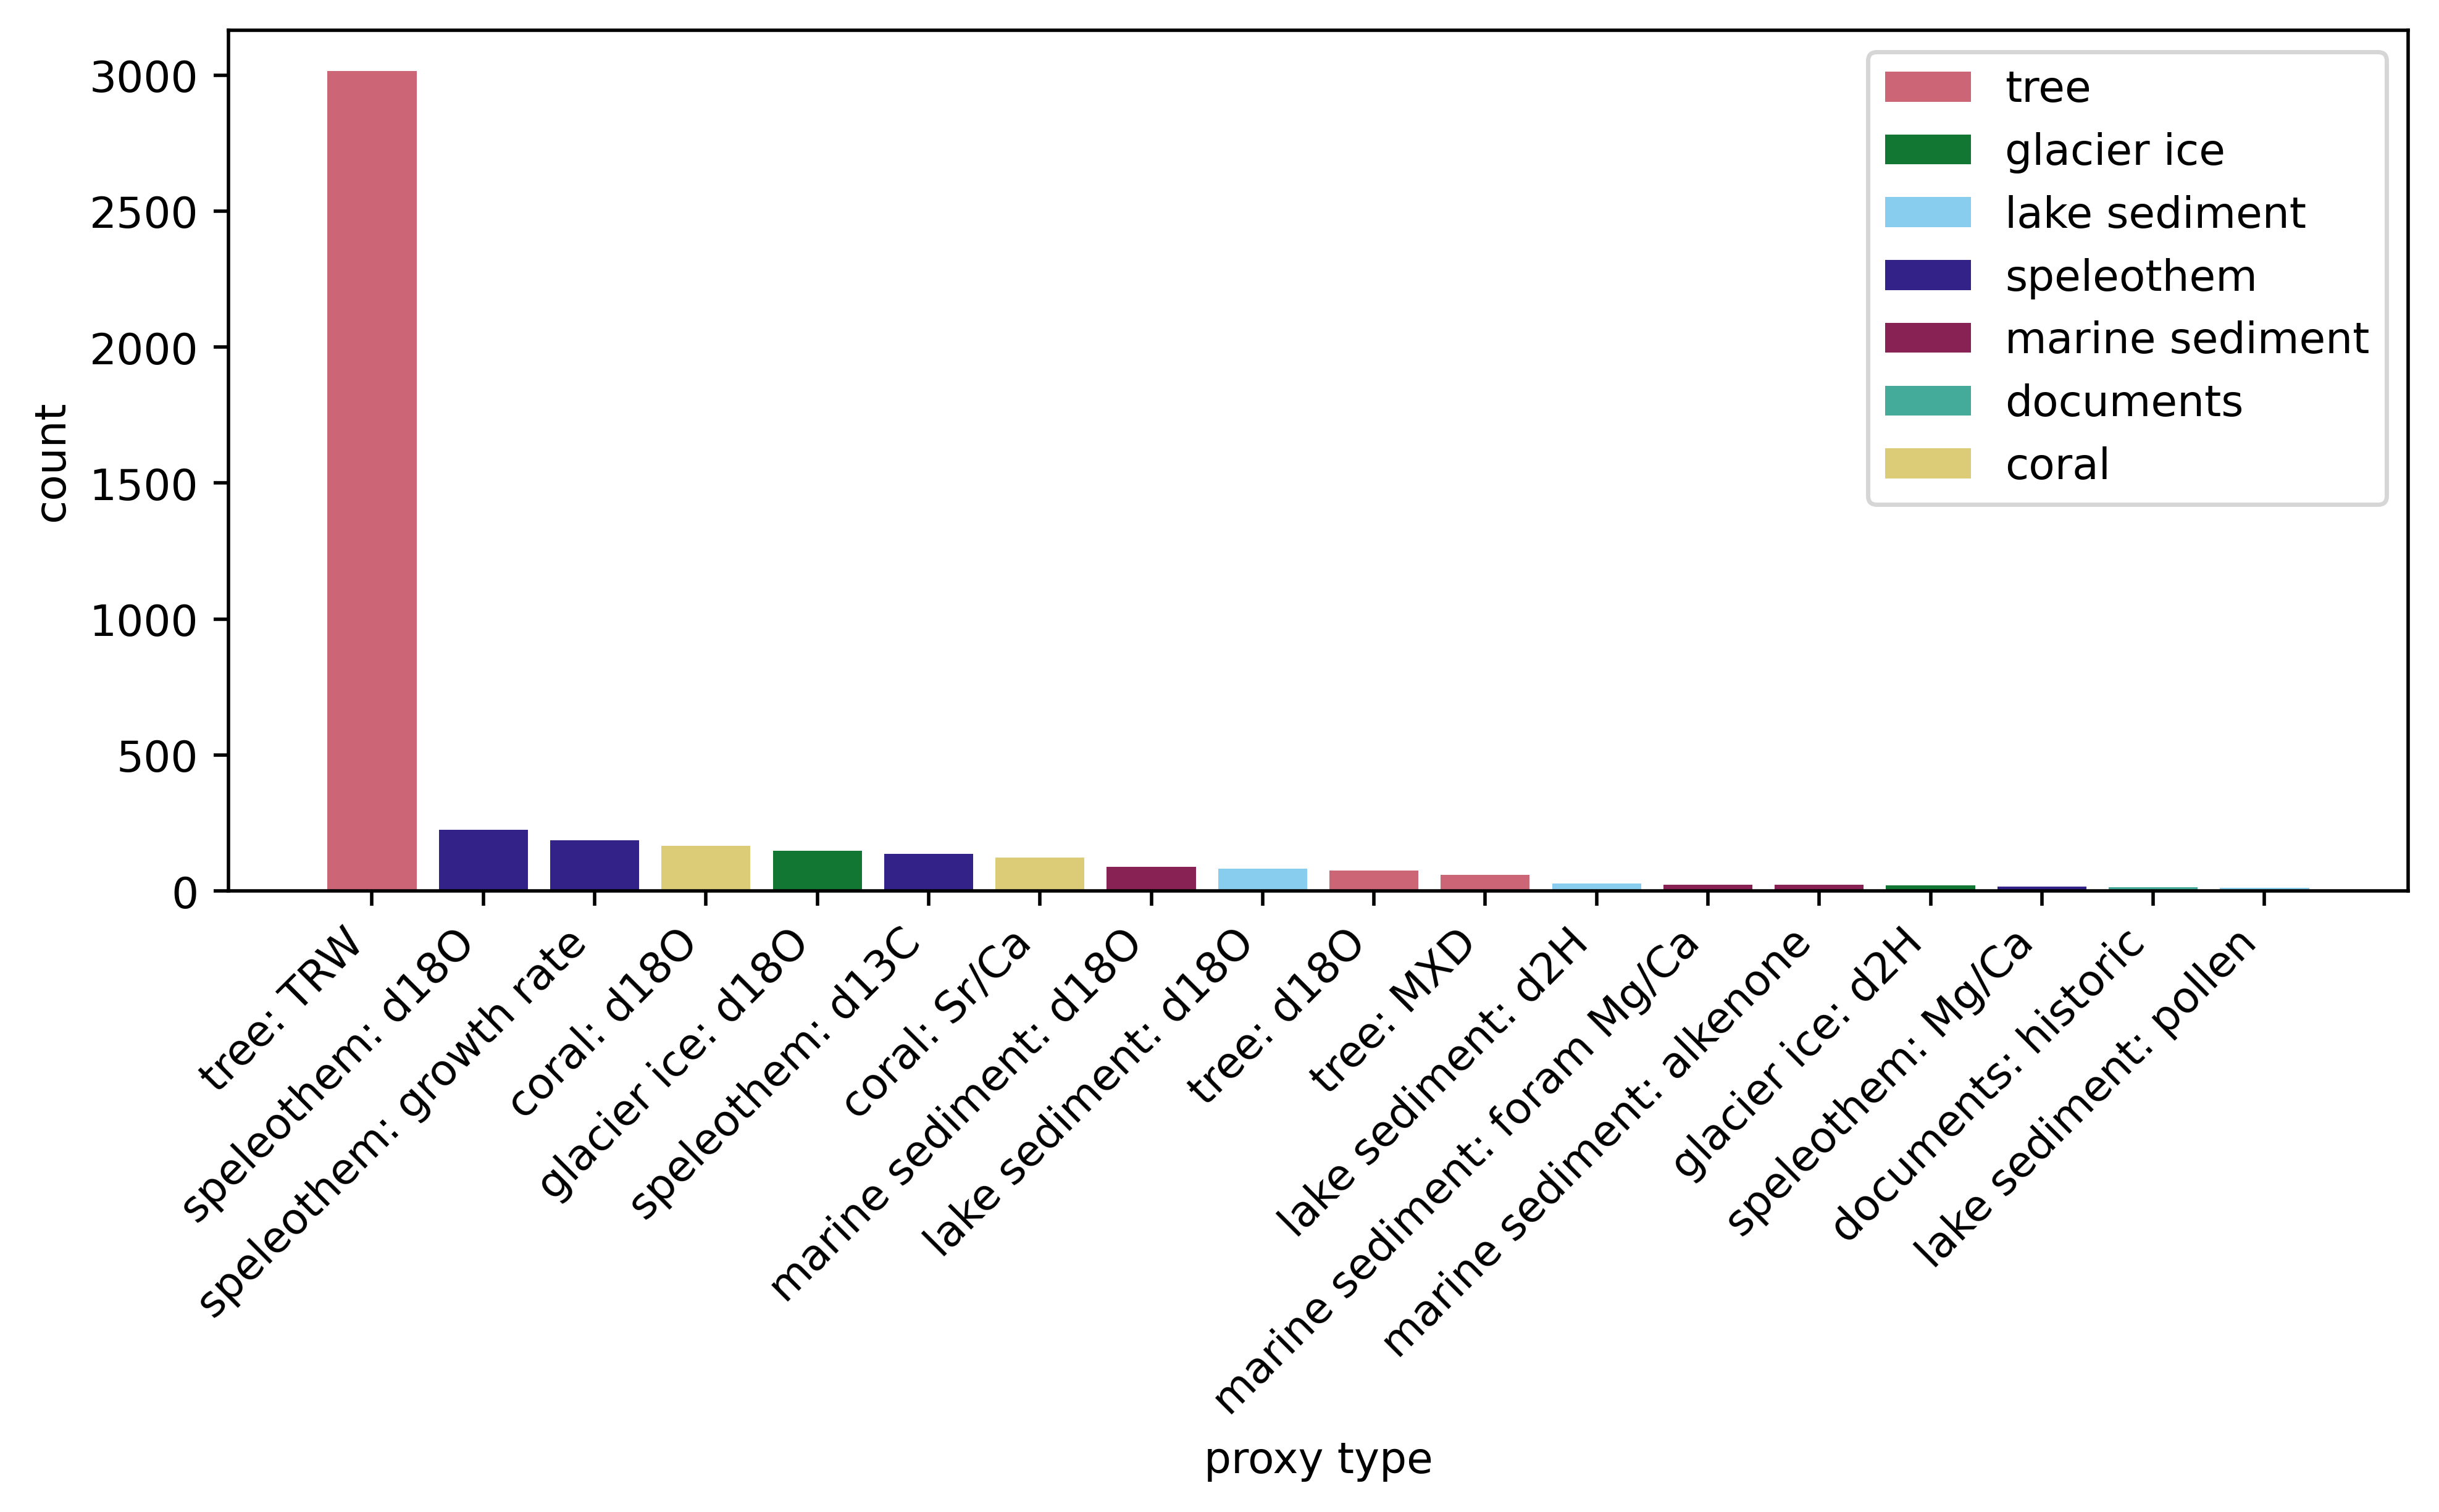

In [17]:
# plot a bar chart of the number of proxy types included in the dataset
# only shows proxy types with n>10

fig = plt.figure(figsize=(8, 5), dpi=500)
ax  = plt.gca()
count_by_proxy_short   = [archive_proxy_count[tt] for tt in archive_proxy_ticks if archive_proxy_count[tt]>10 ]
ticks_by_proxy_short   = [tt for tt in archive_proxy_ticks if archive_proxy_count[tt]>10 ]
cols_by_proxy_short    = [archive_colour[tt.split(':')[0]] for tt in archive_proxy_ticks if archive_proxy_count[tt]>10 ]
archive_by_proxy_short = [tt.split(':')[0] for tt in archive_proxy_ticks if archive_proxy_count[tt]>10 ]

sort = np.argsort(count_by_proxy_short)[::-1]

# create placeholder artists for legend and clean axis again
plt.bar(range(len(set(archive_by_proxy_short))), range(len(set(archive_by_proxy_short))), 
        color=[archive_colour[aa] for aa in set(archive_by_proxy_short)],
        label=set(archive_by_proxy_short))
h, l = ax.get_legend_handles_labels()
plt.legend()
ax.cla()

plt.bar(np.arange(len(ticks_by_proxy_short)), 
        np.array(count_by_proxy_short)[sort], 
        color=np.array(cols_by_proxy_short)[sort])

plt.xlabel('proxy type')
plt.ylabel('count')
ax.set_xticks(np.arange(len(ticks_by_proxy_short)), 
              [ticks_by_proxy_short[ii] for ii in sort], 
              rotation=45, ha='right', fontsize=10)
plt.legend(h[::-1], l[::-1])


fig.tight_layout()

f.figsave(fig, '%s_proxy_comp_short'%df.name, addfigs='/%s/figs/'%df.name)


saved figure in /dod2k_dupfree_dupfree/figs///dod2k_dupfree_dupfree_proxy_comp_long.pdf


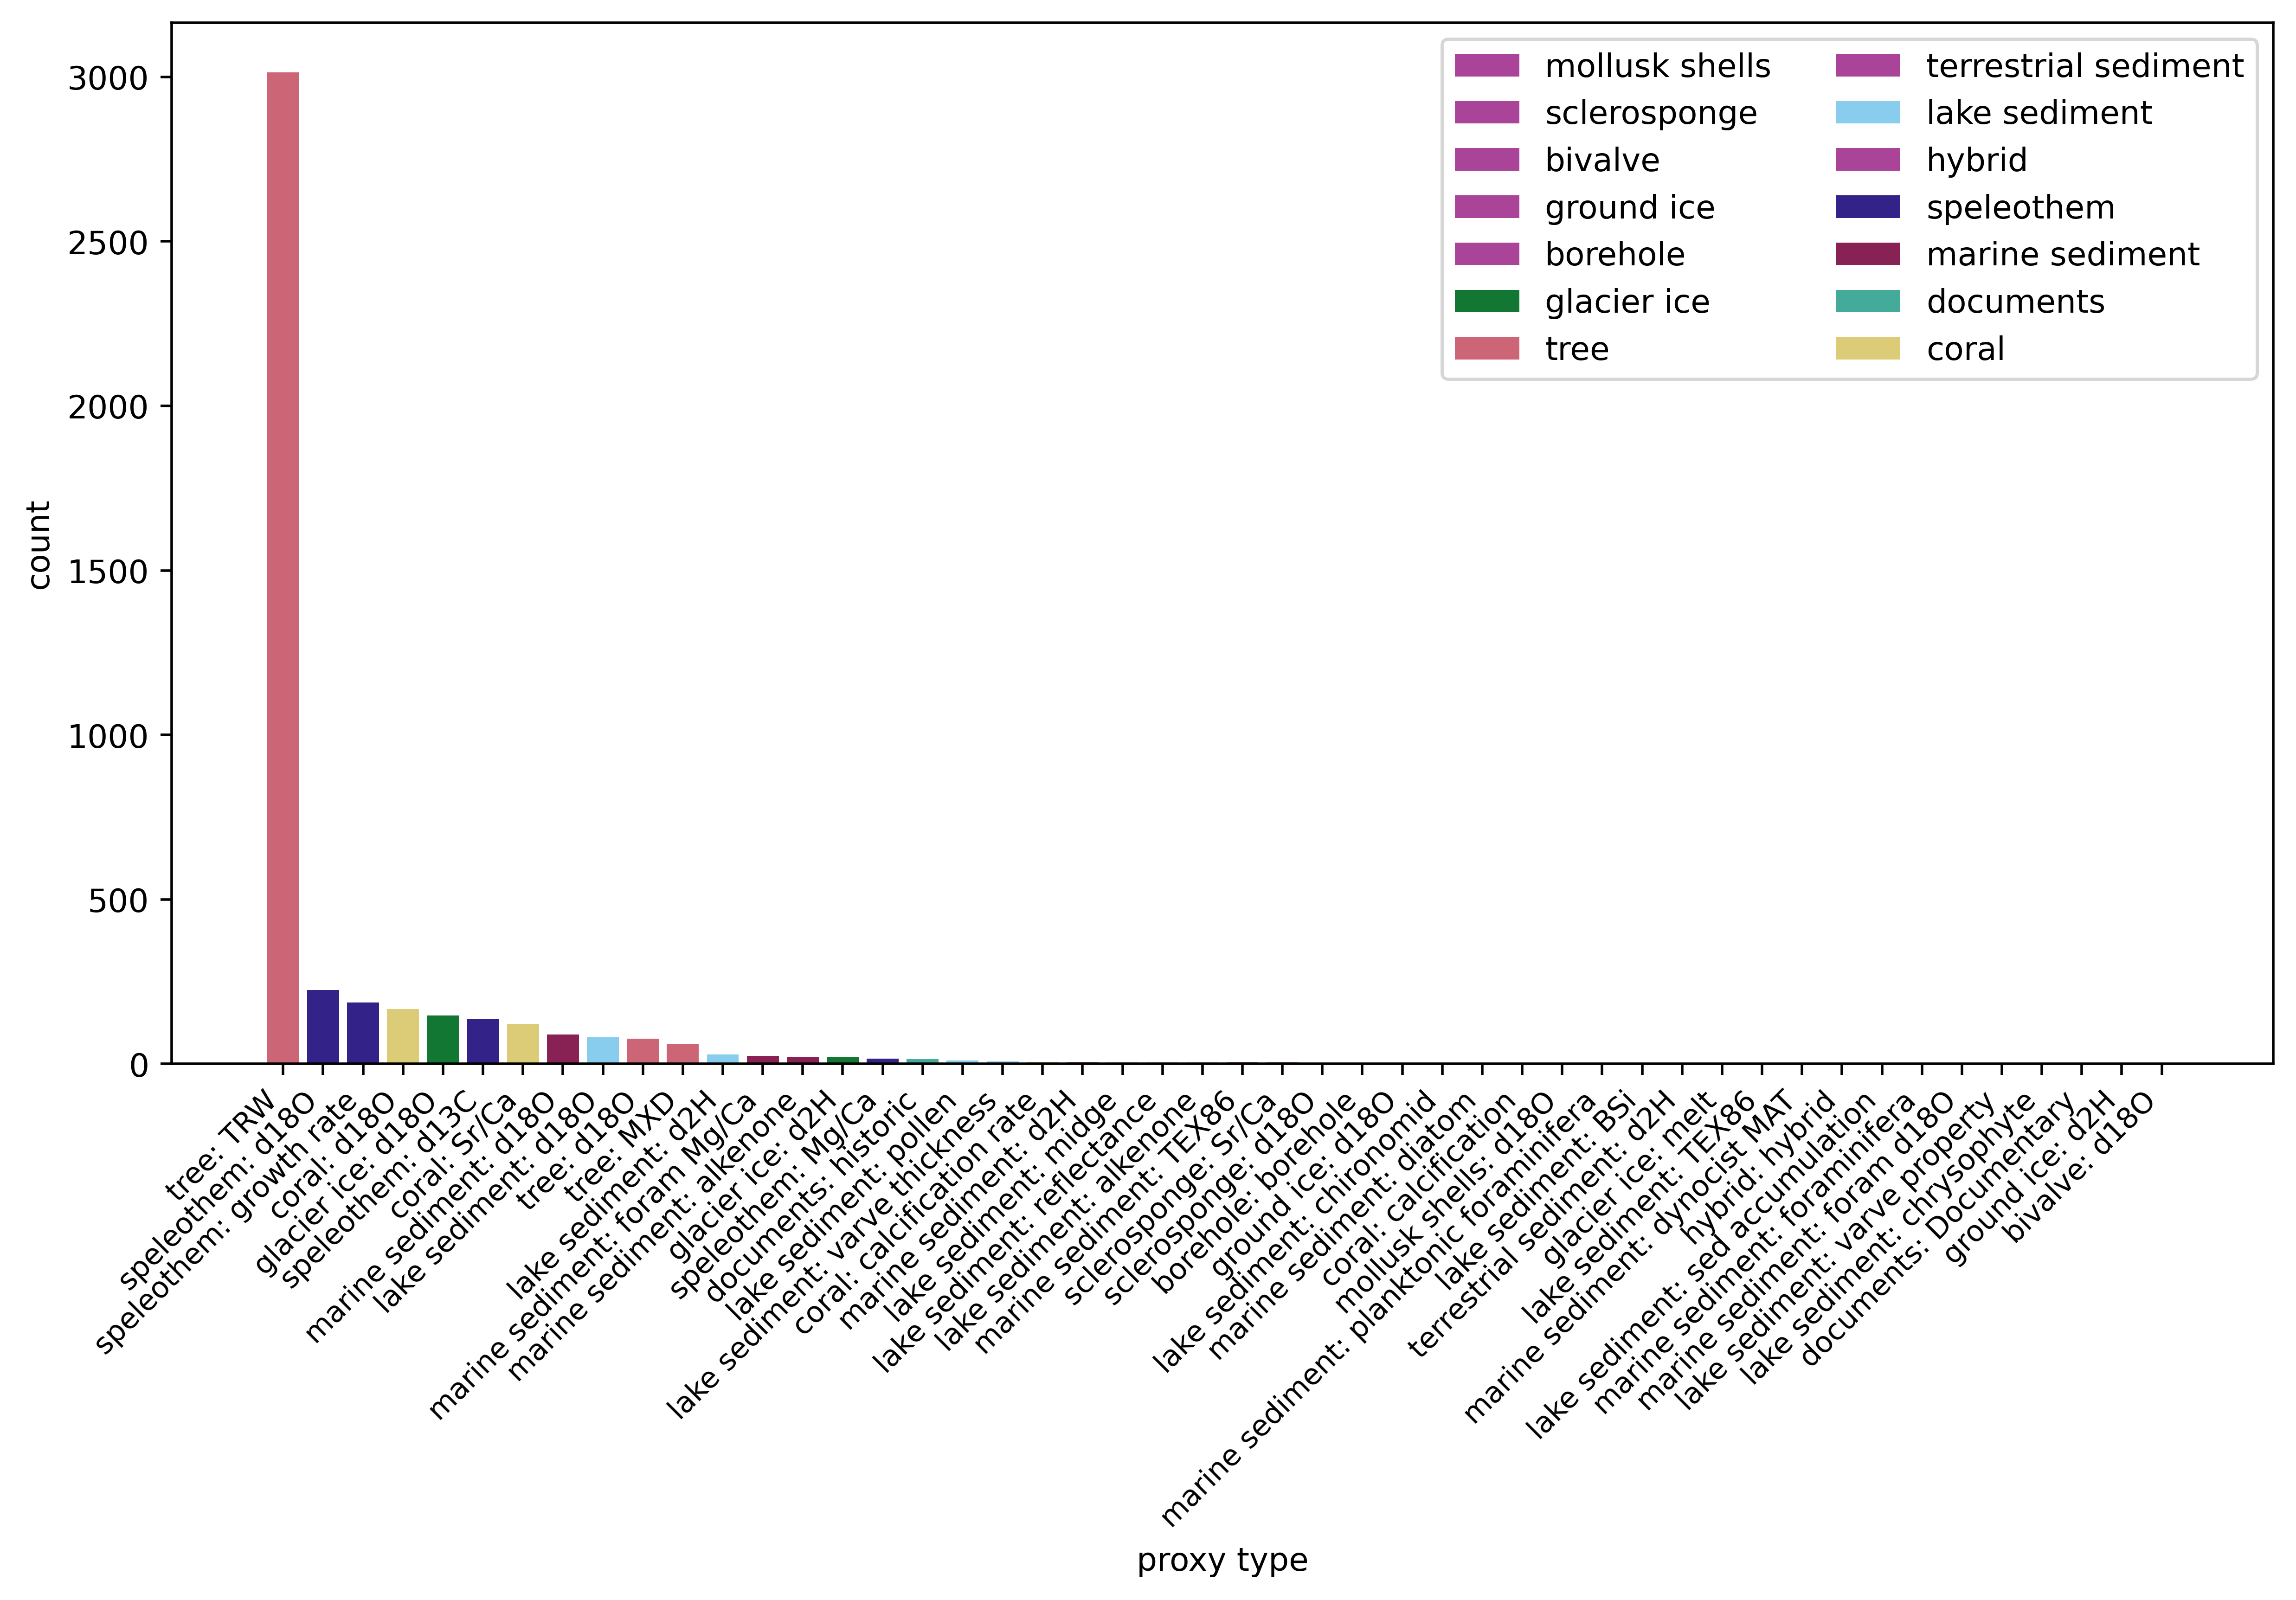

In [18]:
# plot a bar chart of the number of proxy types included in the dataset
# only shows proxy types with n>10

fig = plt.figure(figsize=(10, 7), dpi=500)
ax  = plt.gca()
count_by_proxy_long   = [archive_proxy_count[tt] for tt in archive_proxy_ticks]
ticks_by_proxy_long   = [tt for tt in archive_proxy_ticks]
cols_by_proxy_long    = [archive_colour[tt.split(':')[0]] for tt in archive_proxy_ticks ]
archive_by_proxy_long = [tt.split(':')[0] for tt in archive_proxy_ticks]

sort = np.argsort(count_by_proxy_long)[::-1]

# create placeholder artists for legend and clean axis again
plt.bar(range(len(set(archive_by_proxy_long))), range(len(set(archive_by_proxy_long))), 
        color=[archive_colour[aa] for aa in set(archive_by_proxy_long)],
        label=set(archive_by_proxy_long))
h, l = ax.get_legend_handles_labels()
plt.legend()
ax.cla()

plt.bar(np.arange(len(ticks_by_proxy_long)), 
        np.array(count_by_proxy_long)[sort], 
        color=np.array(cols_by_proxy_long)[sort])

plt.xlabel('proxy type')
plt.ylabel('count')
ax.set_xticks(np.arange(len(ticks_by_proxy_long)), 
              [ticks_by_proxy_long[ii] for ii in sort], 
              rotation=45, ha='right', fontsize=9)
plt.legend(h[::-1], l[::-1], ncol=2)


fig.tight_layout()

f.figsave(fig, '%s_proxy_comp_long'%df.name, addfigs='/%s/figs/'%df.name)


## temporal availability of database, by archive type

In [19]:
#%% plot the coverage of all records and coverage per archive 

MinY     = np.array([min([float(sy) for sy in yy])  for yy in df['year']]) # find minimum year for each record
MaxY     = np.array([max([float(sy) for sy in yy])  for yy in df['year']]) # find maximum year for each record
years    = np.arange(min(MinY), max(MaxY)+1)

# generate array of coverage (how many records are available each year, in total)
coverage = np.zeros(years.shape[0])
for ii in range(len(df['year'])):
    coverage[(years>=MinY[ii])&(years<=MaxY[ii])] += 1

In [20]:
# generate array of coverage for each archive type
coverage_by_archive = {arch: np.zeros(years.shape[0]) for arch in major_archives+['other'] }
for arch in archives_sorted:
    arch_mask = df['archiveType']==arch 
    for ii in range(len(df[arch_mask]['year'])):
        if arch not in major_archives: arch='other'
        cc = coverage_by_archive[arch]
        coverage_by_archive[arch][(years>=MinY[arch_mask][ii])&(years<=MaxY[arch_mask][ii])] += 1

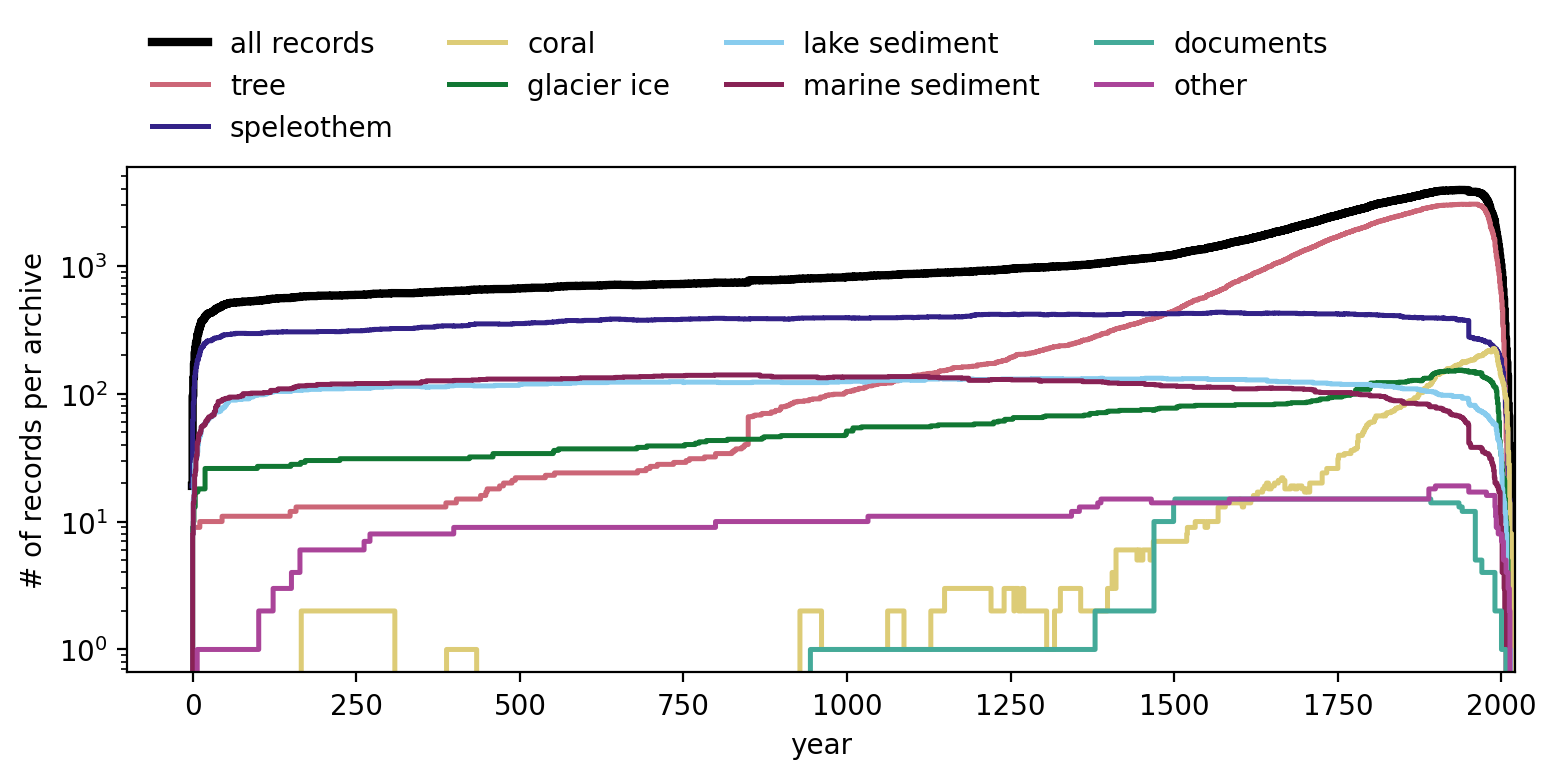

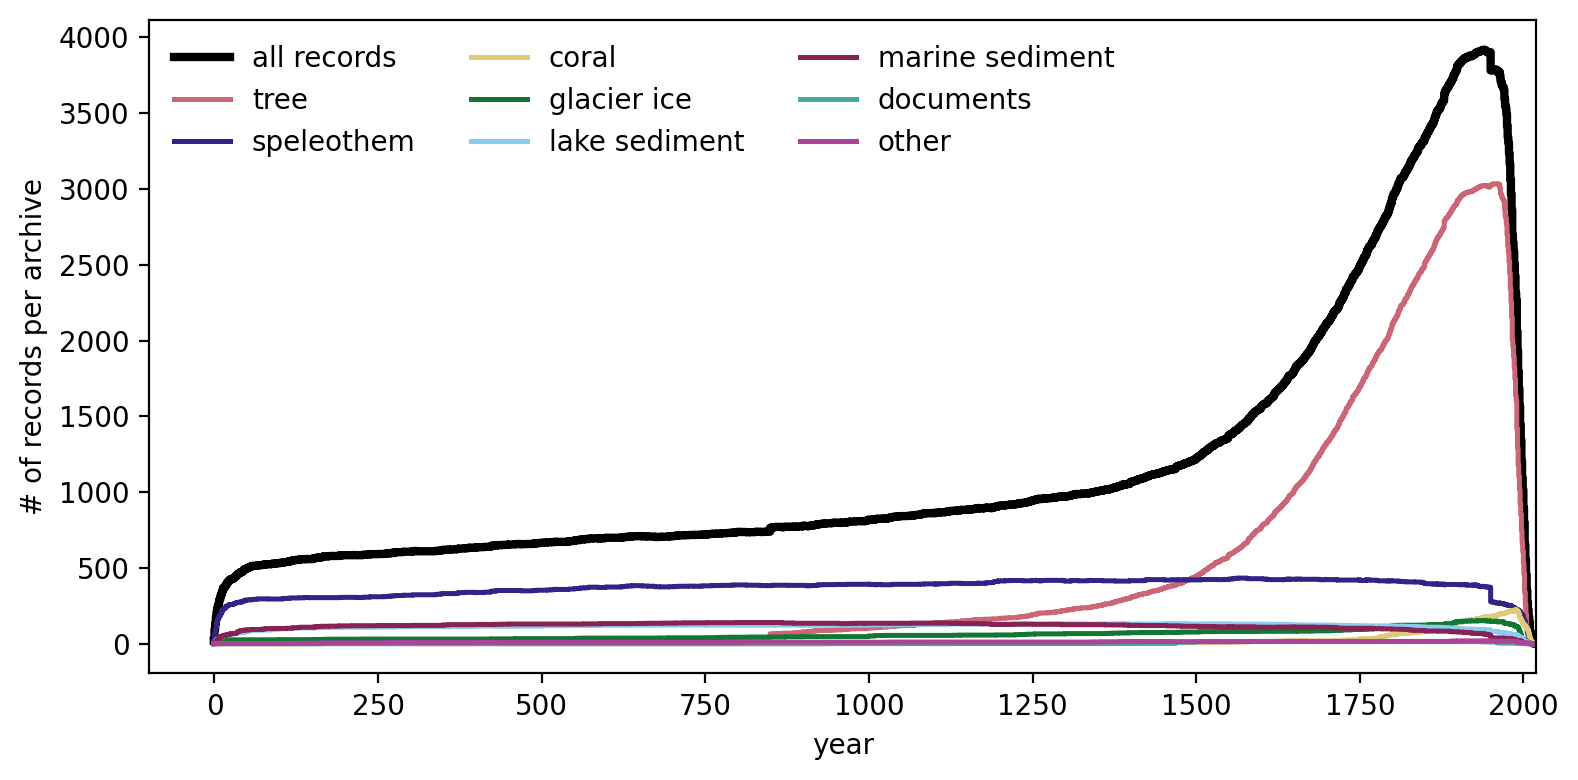

In [21]:
# plot outcome on two axis (left: total records, right: coverage per archive)

for ysc in ['log', 'linear']:
    fig = plt.figure(figsize=(8, 4), dpi=200)
    ax = plt.gca()
    plt.step(years, coverage, color='k', label='all records', lw=3)
    plt.xlabel('year')
    plt.ylabel('total # of records')
    
    plt.xlim(-100, 2020)
    ax.grid(False)
    
    for ii, arch in enumerate(major_archives+['other']):
        plt.step(years, coverage_by_archive[arch], color=archive_colour[arch],
                 label=arch, lw=1.8)
    
    h1, l1 = ax.get_legend_handles_labels()
    if ysc=='log':plt.legend(h1, [ll.replace(' ',' ') for ll in l1], 
                             ncol=4, framealpha=0, bbox_to_anchor=(0,1), loc='lower left' )
    else:plt.legend(h1, l1, ncol=3, framealpha=0)
    plt.ylabel('# of records per archive')
    fig.tight_layout()
    plt.yscale(ysc)
    # f.figsave(fig, '%s_temporal_avail'%df.name+'_%s'%ysc.upper(), 
    #           addfigs='/%s/figs/'%df.name)


In [22]:
#%% plot the coverage of all records and coverage per archive 
# FOR PAGES2k!!!!

df_pages = f.load_compact_dataframe_from_csv('pages2k')

MinY_pages     = np.array([min([float(sy) for sy in yy])  for yy in df_pages['year']]) # find minimum year for each record
MaxY_pages    = np.array([max([float(sy) for sy in yy])  for yy in df_pages['year']]) # find maximum year for each record
years_pages    = np.arange(min(MinY_pages), max(MaxY_pages)+1)

# generate array of coverage (how many records are available each year, in total)
coverage_pages = np.zeros(years_pages.shape[0])
for ii in range(len(df_pages['year'])):
    coverage_pages[(years_pages>=MinY_pages[ii])&(years_pages<=MaxY_pages[ii])] += 1

In [23]:
# generate array of coverage for each archive type
# FOR PAGES2k!!!!

coverage_by_archive_pages = {arch: np.zeros(years_pages.shape[0]) for arch in major_archives+['other'] }
for arch in set(df_pages['archiveType']):
    arch_mask = df_pages['archiveType']==arch 
    for ii in range(len(df_pages[arch_mask]['year'])):
        if arch not in major_archives: arch='other'
        cc = coverage_by_archive_pages[arch]
        coverage_by_archive_pages[arch][(years_pages>=MinY_pages[arch_mask][ii])&(years_pages<=MaxY_pages[arch_mask][ii])] += 1
        

saved figure in /dod2k_dupfree_dupfree/figs///dod2k_dupfree_dupfree_temporal_avail_compared_to_PAGES2k_LOG.pdf
saved figure in /dod2k_dupfree_dupfree/figs///dod2k_dupfree_dupfree_temporal_avail_compared_to_PAGES2k_LINEAR.pdf


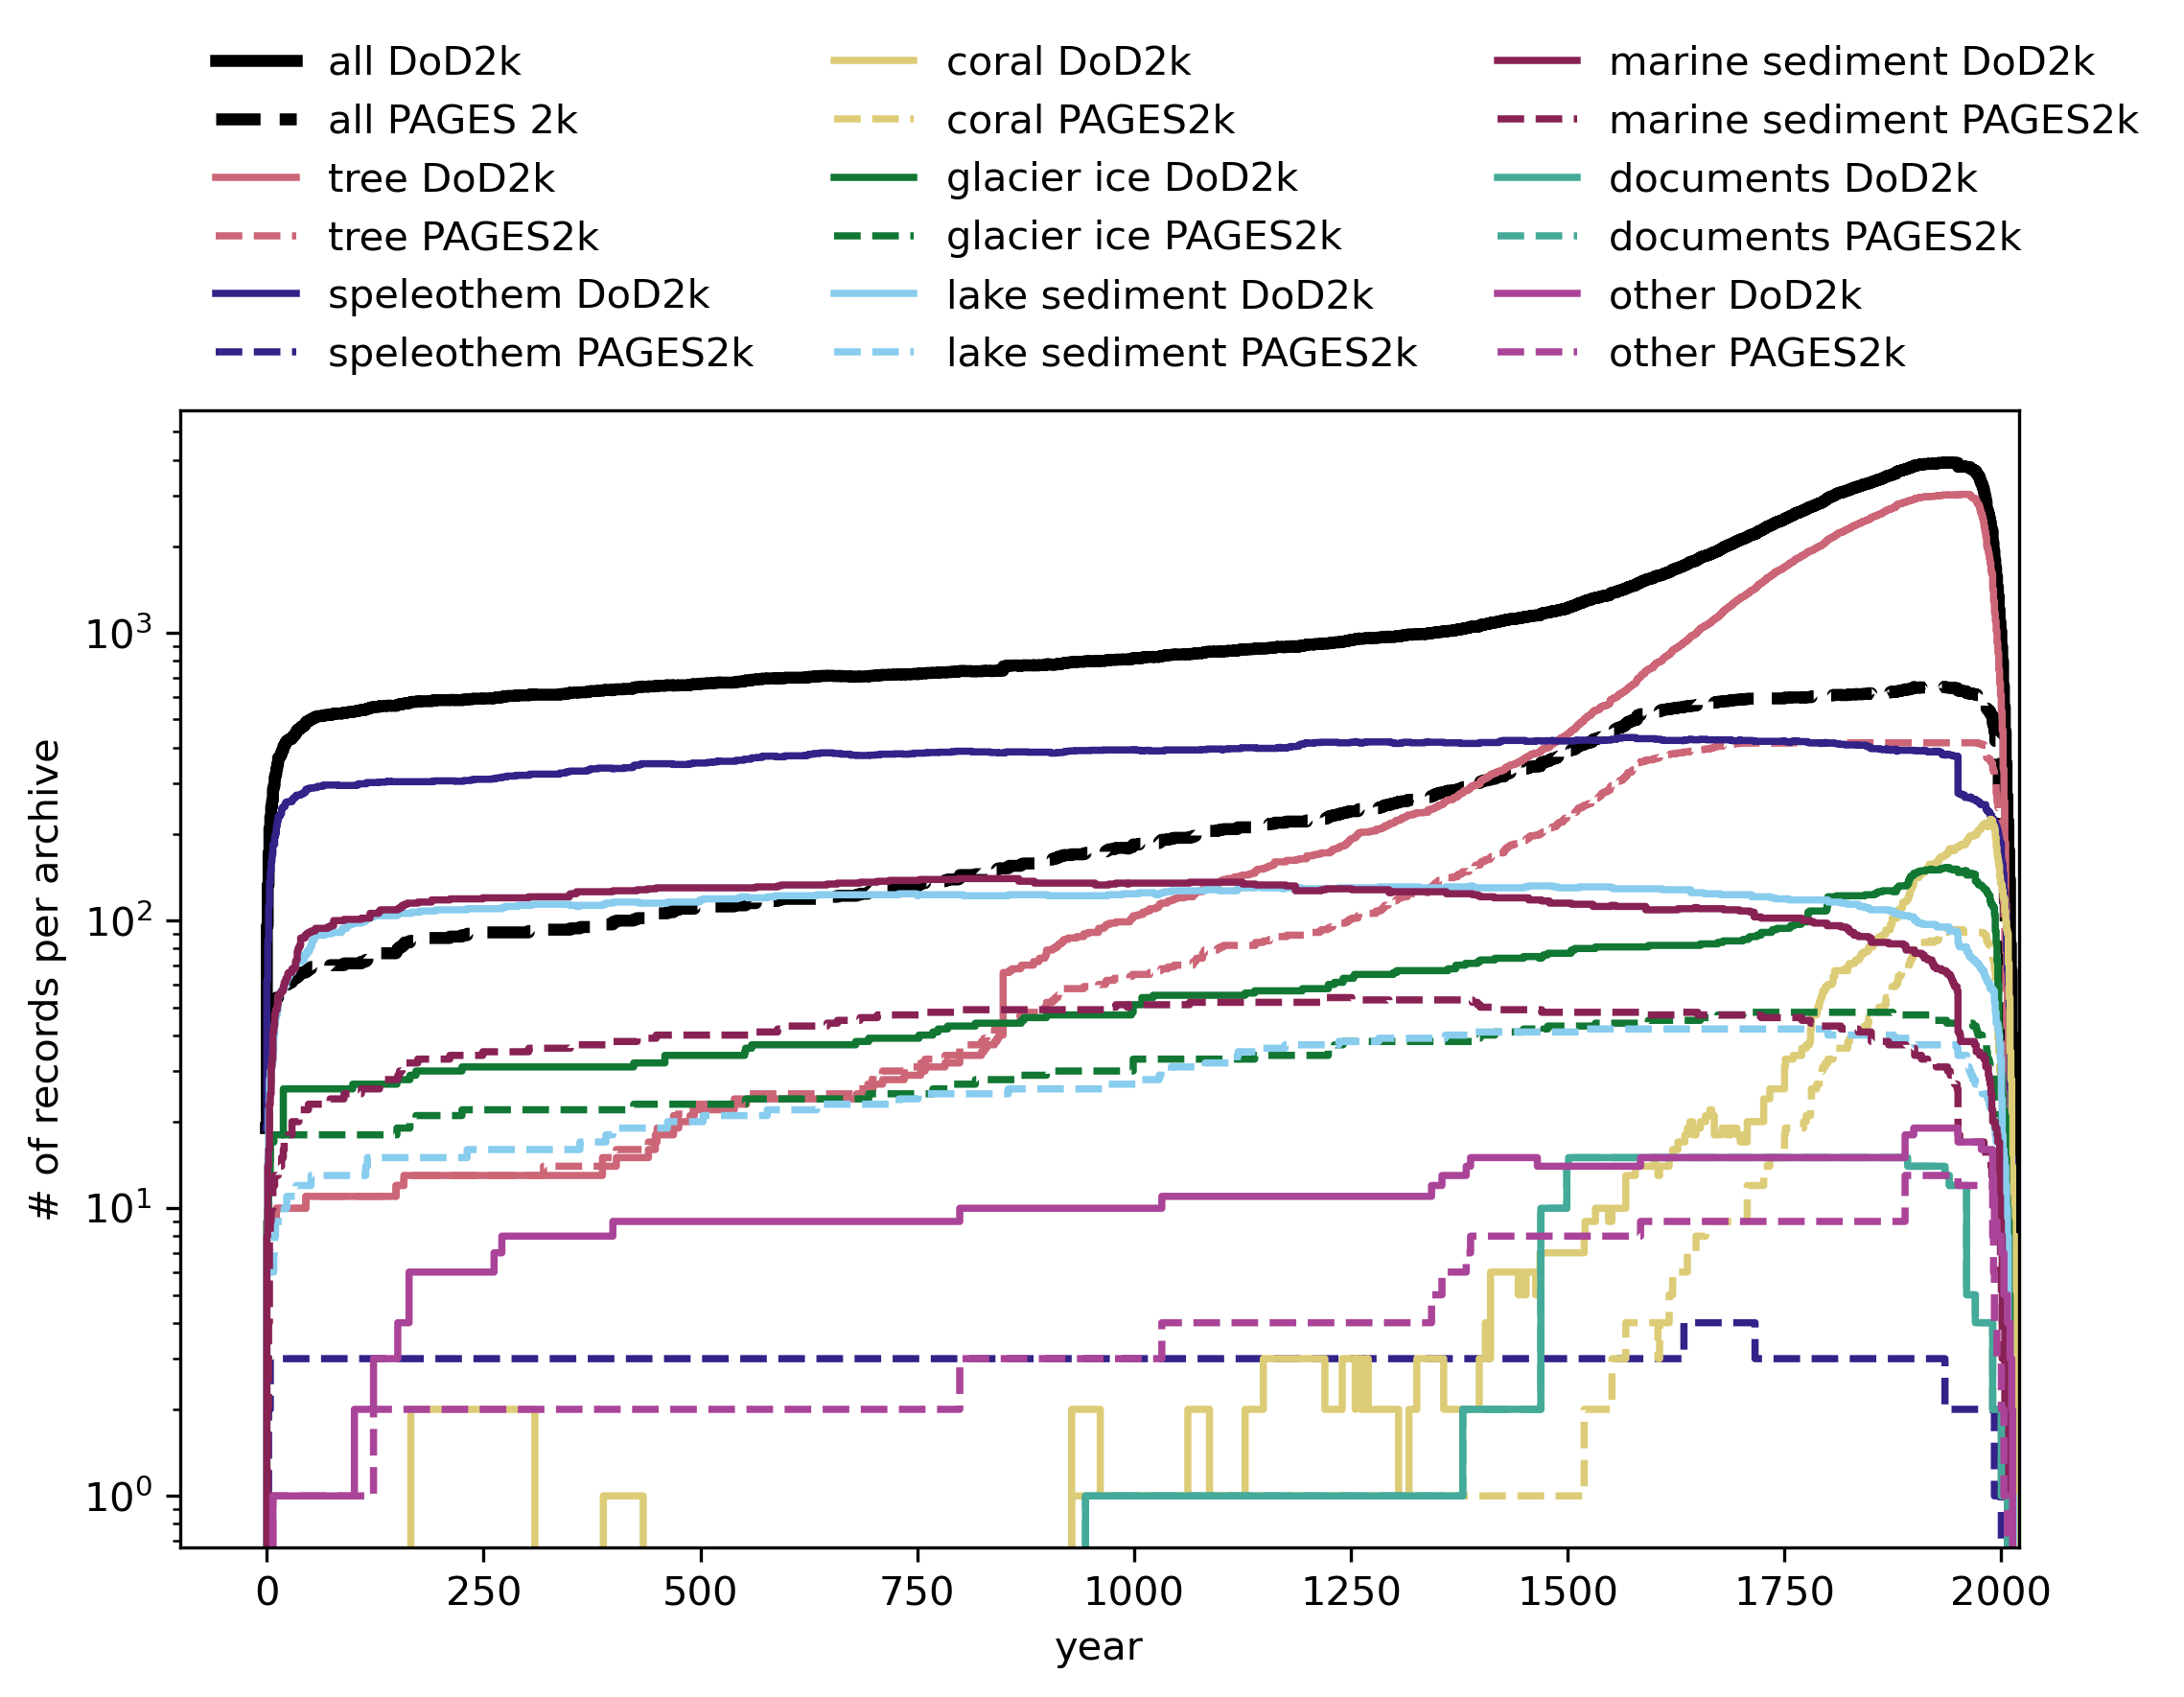

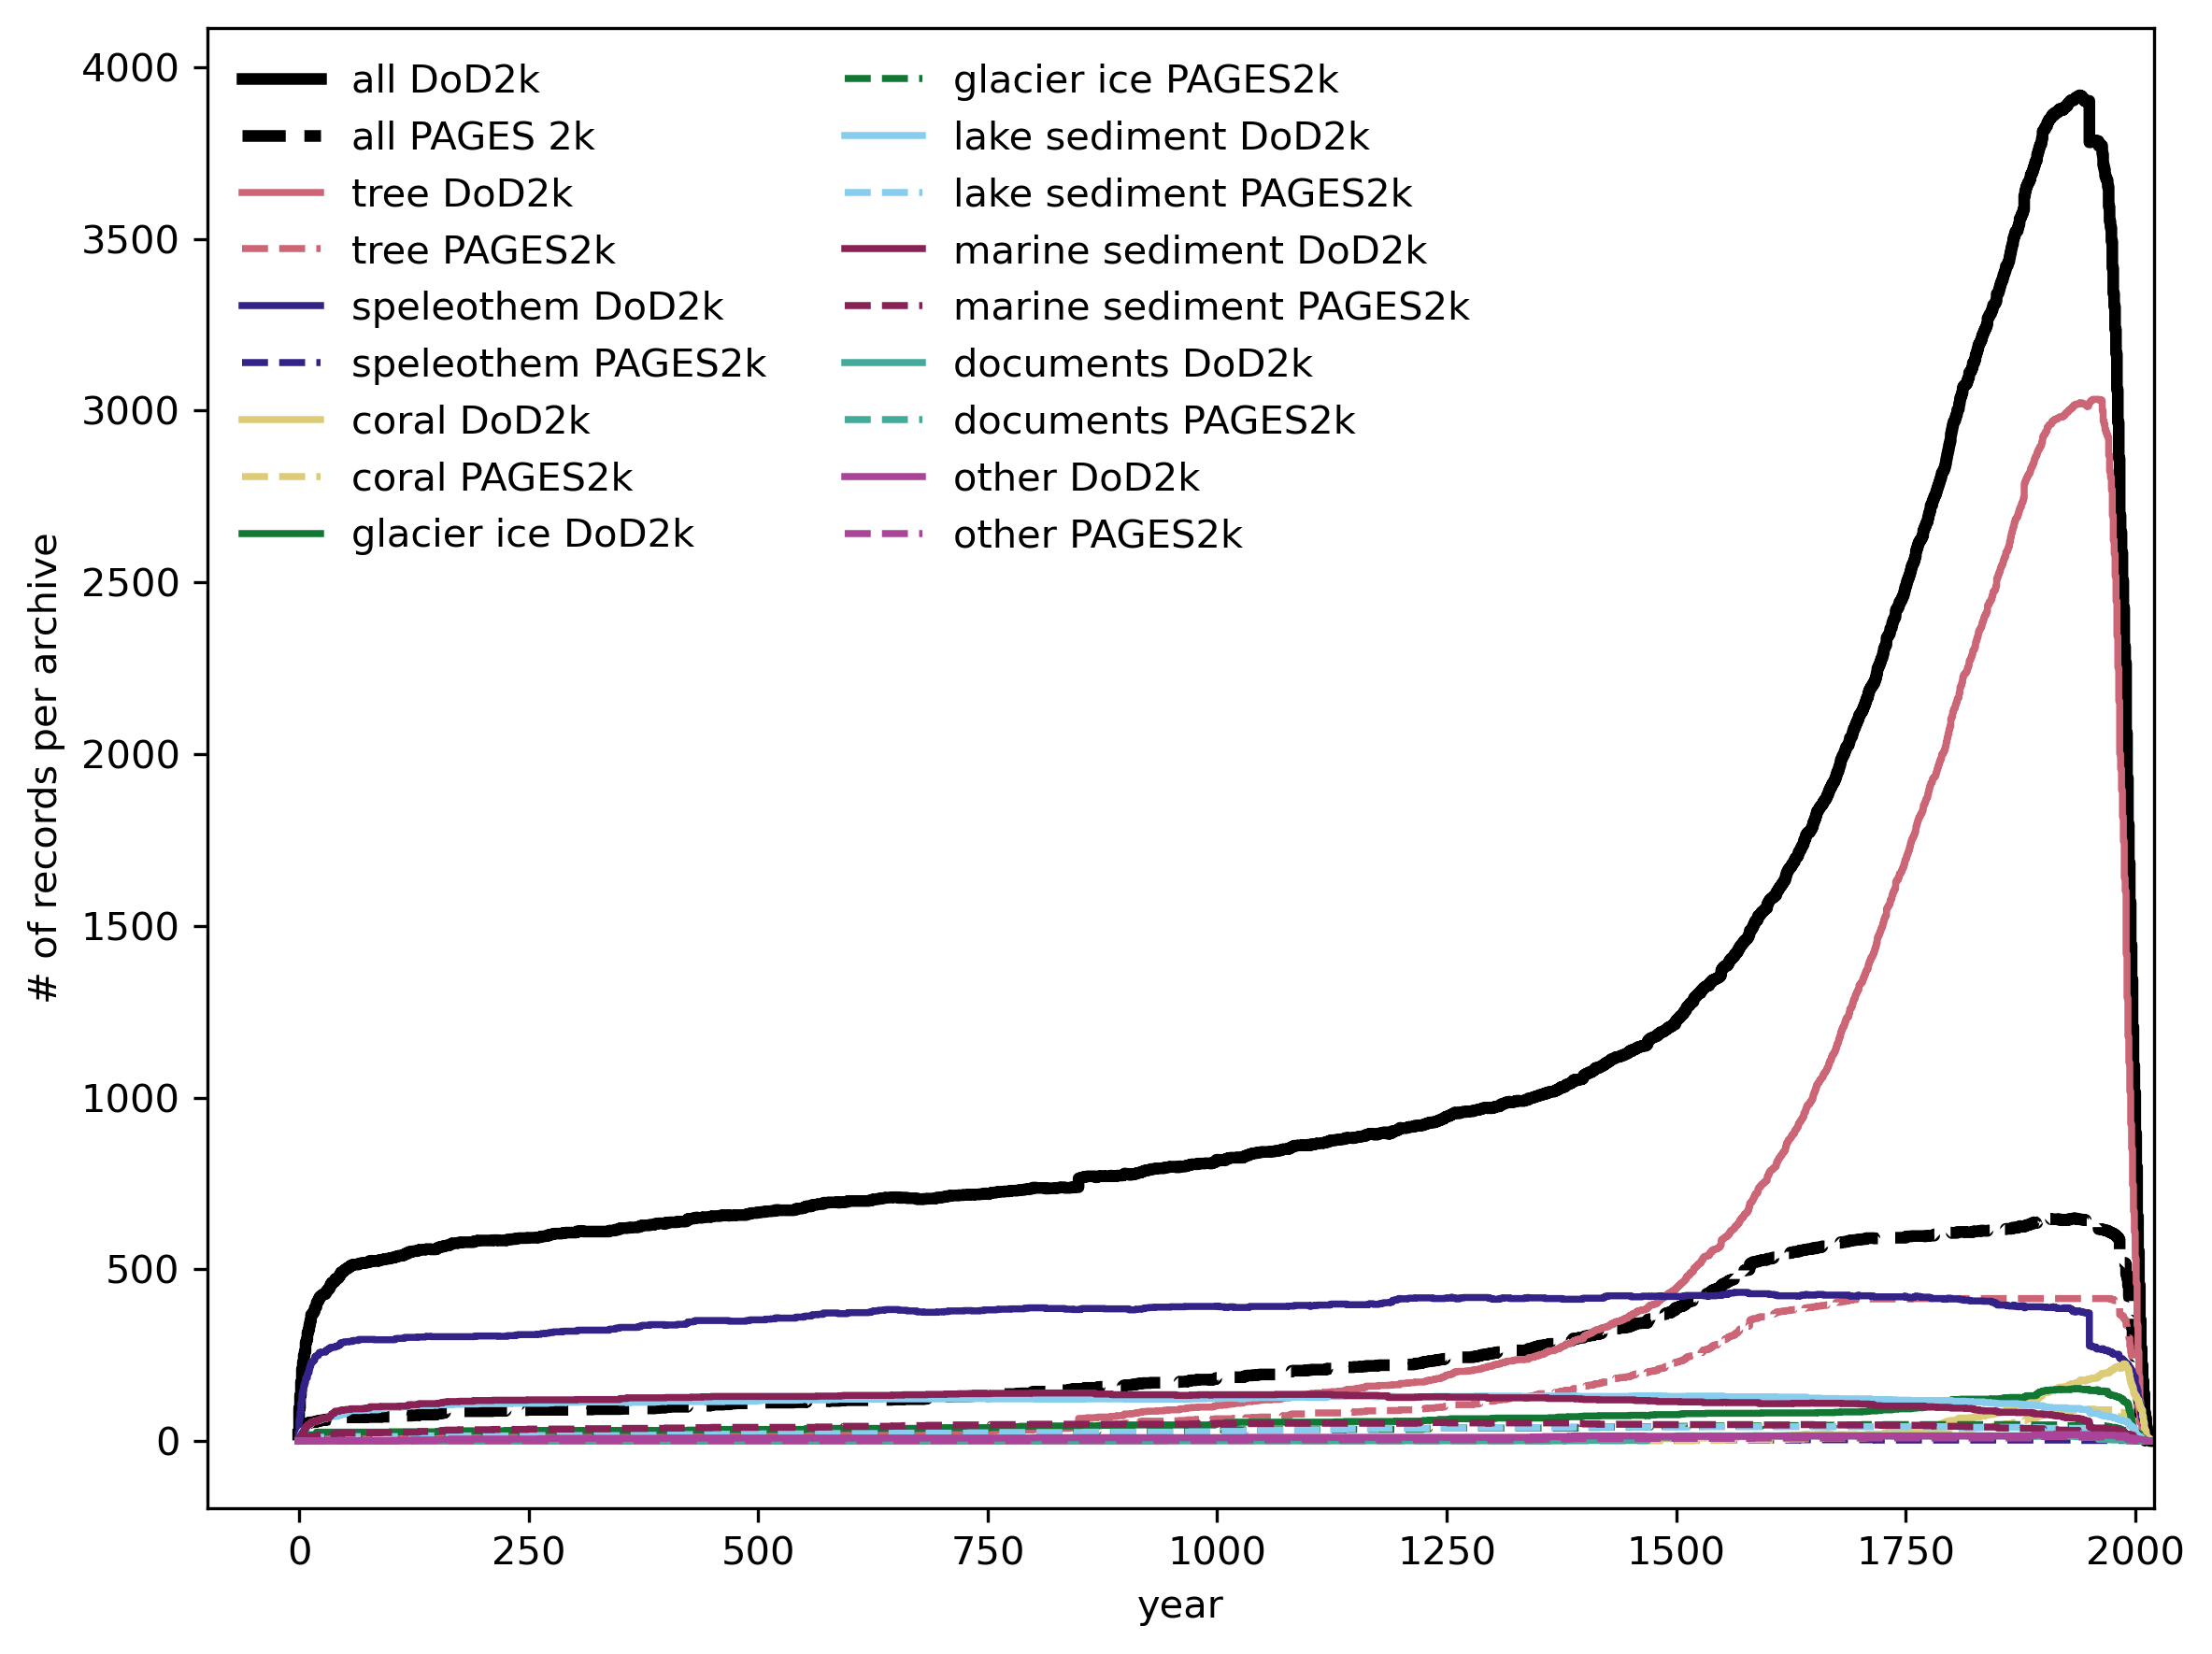

In [24]:
# plot outcome on two axis (left: total records, right: coverage per archive)
# FOR PAGES2k!!!!

for ysc in ['log', 'linear']:
    fig = plt.figure(figsize=(8, 6), dpi=300)
    ax = plt.gca()
    plt.step(years, coverage, color='k', label='all DoD2k', lw=3)
    plt.step(years_pages, coverage_pages, color='k', 
             label='all PAGES 2k', lw=3, ls='--')
    plt.xlabel('year')
    plt.ylabel('total # of records')
    
    plt.xlim(-100, 2020)
    ax.grid(False)
    
    for ii, arch in enumerate(major_archives+['other']):
        plt.step(years, coverage_by_archive[arch], color=archive_colour[arch],
                 label=arch+' DoD2k', lw=1.8)
        plt.step(years_pages, coverage_by_archive_pages[arch], 
                 color=archive_colour[arch], ls='--',
                 label=arch+' PAGES2k', lw=1.8)
    
    h1, l1 = ax.get_legend_handles_labels()
    if ysc=='log':plt.legend(h1, [ll.replace(' ',' ') for ll in l1], 
                             ncol=3, framealpha=0, bbox_to_anchor=(0,1), loc='lower left' )
    else:plt.legend(h1, l1, ncol=2, framealpha=0)
    plt.ylabel('# of records per archive')
    fig.tight_layout()
    plt.yscale(ysc)
    f.figsave(fig, '%s_temporal_avail_compared_to_PAGES2k'%df.name+'_%s'%ysc.upper(), 
              addfigs='/%s/figs/'%df.name)


In [25]:
# # plot outcome on two axis (left: total records, right: coverage per archive)
# # FOR PAGES2k!!!!


# ysc='log'
# for archive in ['ALL', 'speleothem', 'tree', 'lake sediment', 'marine sediment', 
#                 'coral']:
#     fig = plt.figure(figsize=(8, 6), dpi=300)
#     grid = GS(9,1)
#     ax = plt.subplot(grid[1:,:])
#     if archive=='ALL':
#         plt.step(years, coverage, color='k', label='all DoD2k', lw=3)
#         plt.step(years_pages, coverage_pages, color='k', 
#                  label='all PAGES 2k', lw=3, ls='--')
#     plt.xlabel('year')
#     plt.ylabel('total # of records')
    
#     plt.xlim(-100, 2020)
#     plt.ylim(1, 5000)
#     ax.grid(False)

#     if archive!='ALL':
#         for ii, arch in enumerate(major_archives+['other']):
#             if arch!=archive: continue
#             plt.step(years, coverage_by_archive[arch], color=archive_colour[arch],
#                      label=arch+' DoD2k', lw=1.8)
#             plt.step(years_pages, coverage_by_archive_pages[arch], 
#                      color=archive_colour[arch], ls='--',
#                      label=arch+' PAGES2k', lw=1.8)
#     plt.ylabel('# of records per archive')
#     fig.tight_layout()
#     plt.yscale(ysc)
    
#     h1, l1 = ax.get_legend_handles_labels()
#     l_ax = plt.subplot(grid[0,:])
#     l_ax.legend(h1, [ll.replace(' ',' ') for ll in l1],
#                 ncol=3, framealpha=0, bbox_to_anchor=(0,0), loc='lower left' )
#     l_ax.set_axis_off()
#     f.figsave(fig, '%s_temporal_avail_compared_to_PAGES2k'%df.name+'_%s'%ysc.upper()+'_%s'%archive, 
#               addfigs='/%s/figs/'%df.name)


saved figure in /dod2k_dupfree_dupfree/figs///dod2k_dupfree_dupfree_temporal_avail_compared_to_PAGES2k_LOG.pdf


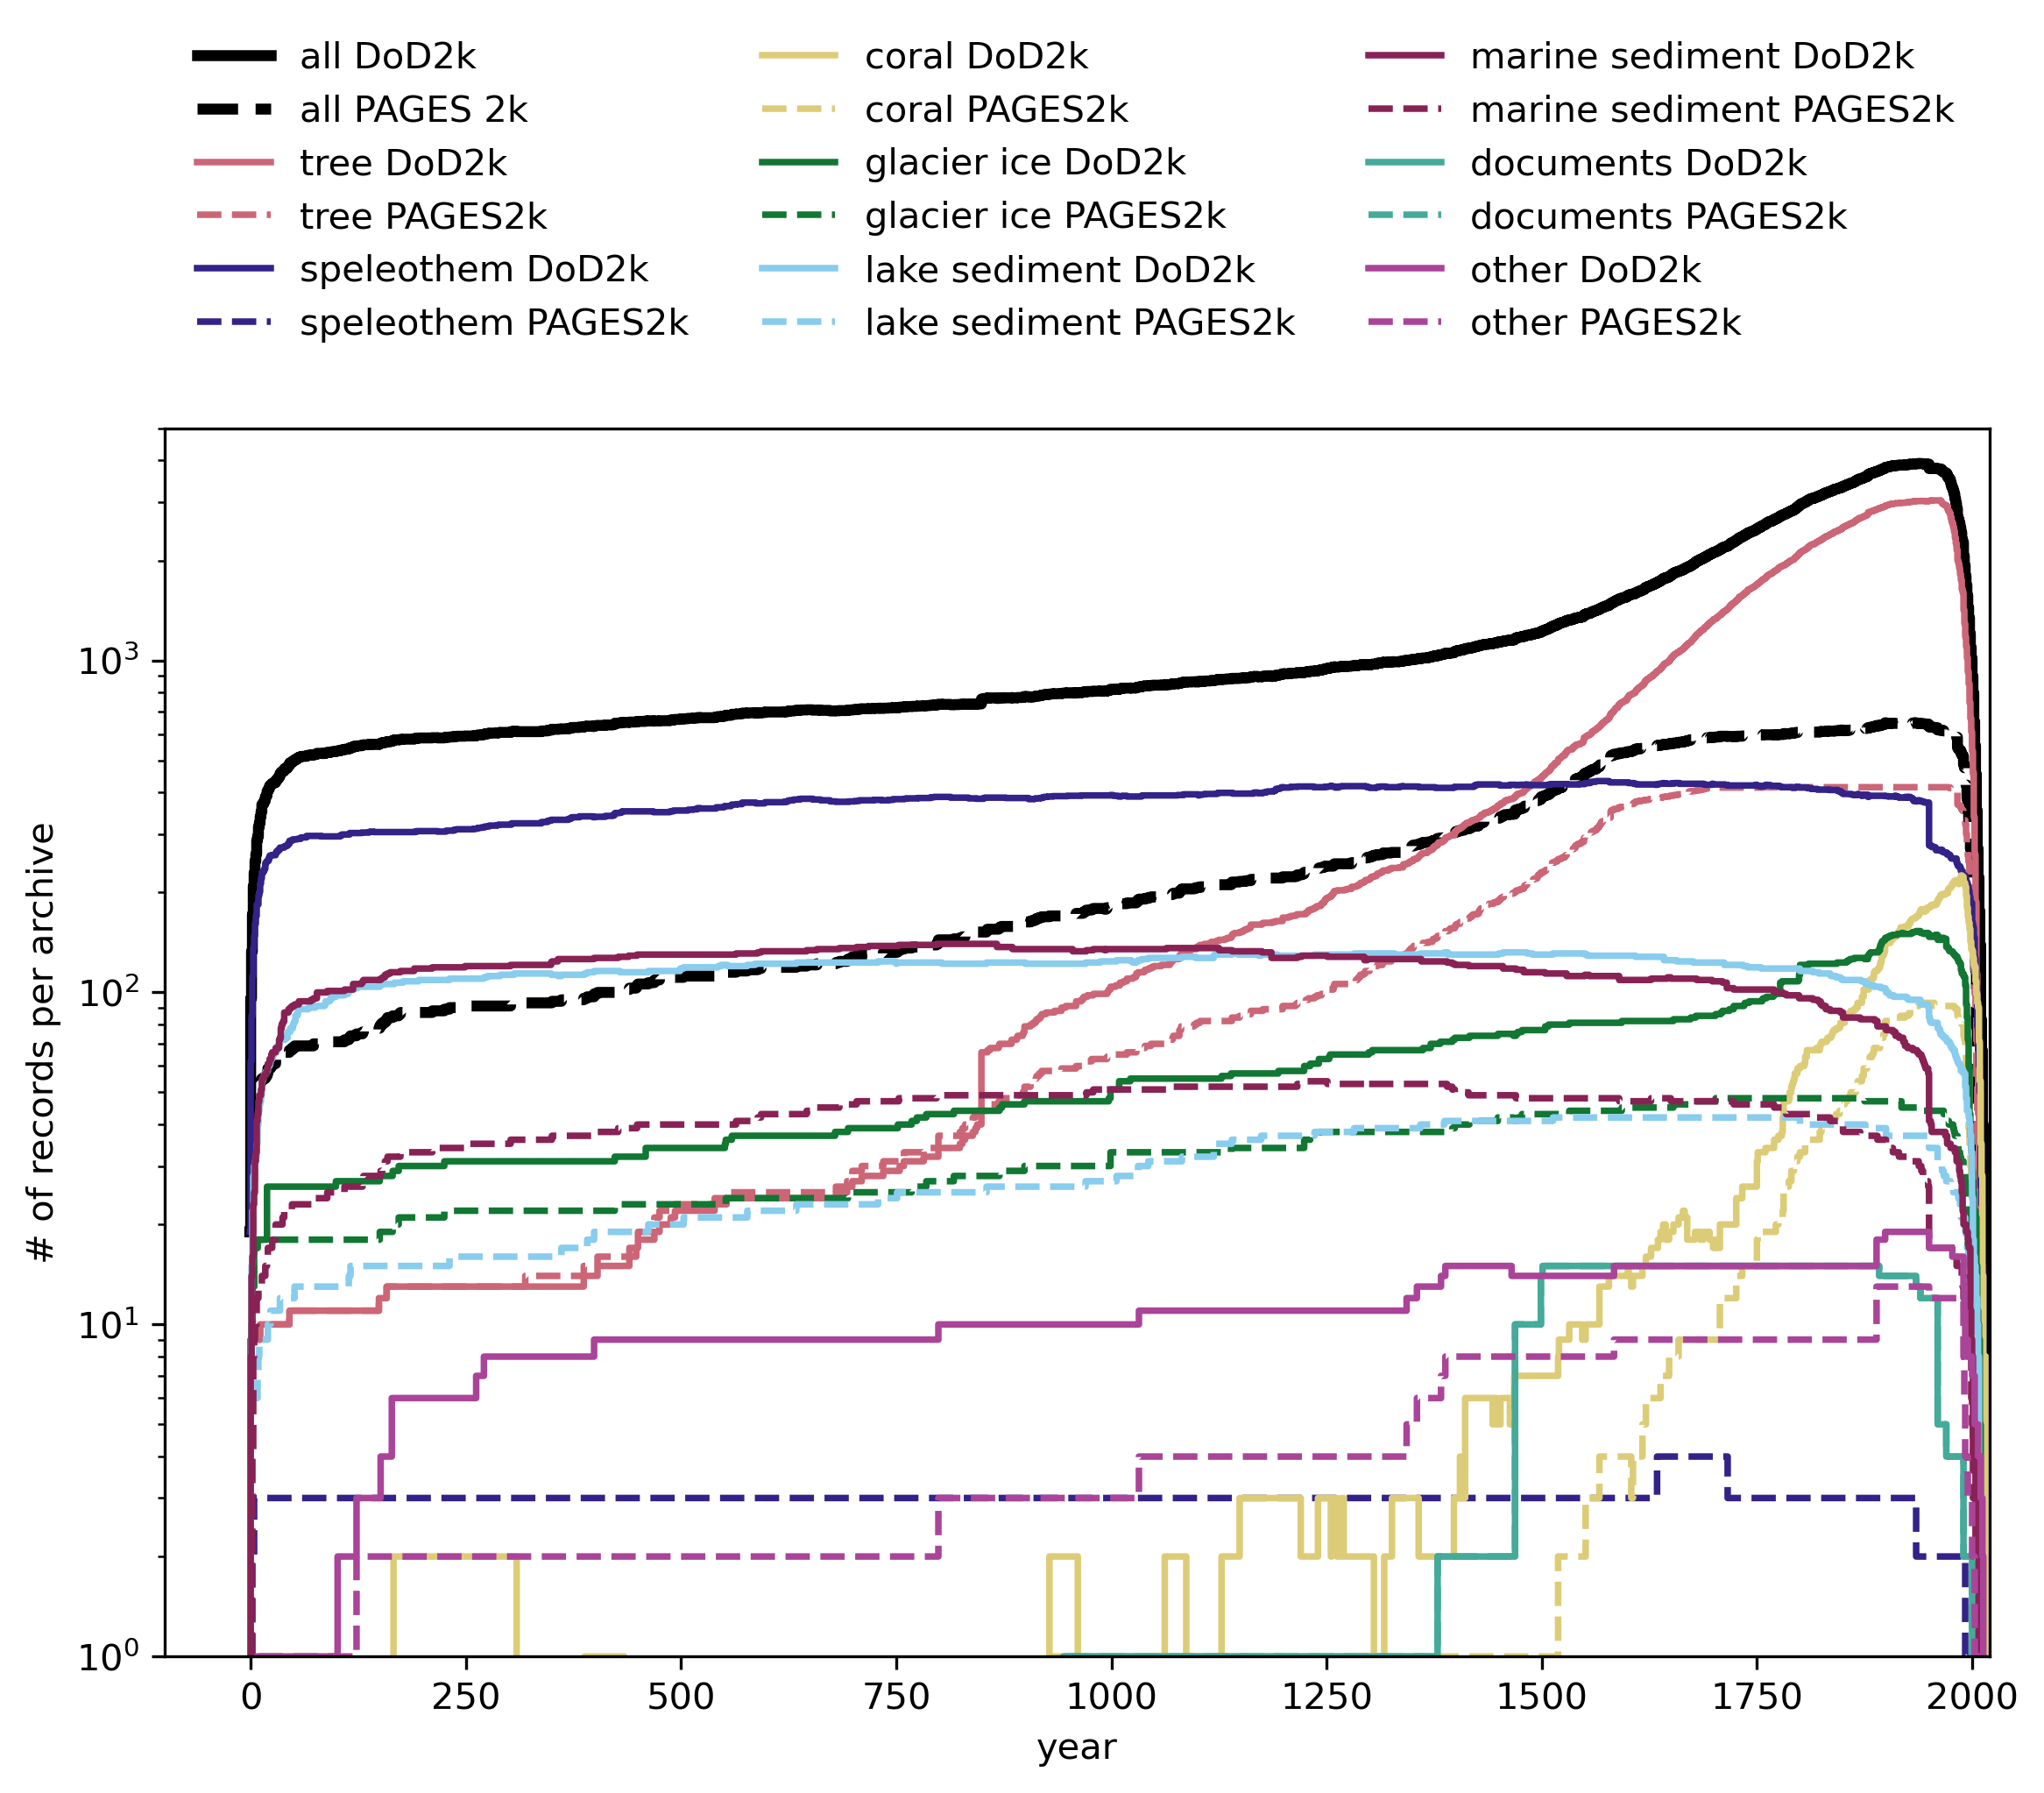

In [26]:
# plot outcome on two axis (left: total records, right: coverage per archive)
# FOR PAGES2k!!!!


ysc='log'

fig = plt.figure(figsize=(8, 6), dpi=300)
grid = GS(9,1)
ax = plt.subplot(grid[1:,:])
plt.step(years, coverage, color='k', label='all DoD2k', lw=3)
plt.step(years_pages, coverage_pages, color='k', 
         label='all PAGES 2k', lw=3, ls='--')
plt.xlabel('year')
plt.ylabel('total # of records')

plt.xlim(-100, 2020)
plt.ylim(1, 5000)
ax.grid(False)

for ii, arch in enumerate(major_archives+['other']):
    plt.step(years, coverage_by_archive[arch], color=archive_colour[arch],
             label=arch+' DoD2k', lw=1.8)
    plt.step(years_pages, coverage_by_archive_pages[arch], 
             color=archive_colour[arch], ls='--',
             label=arch+' PAGES2k', lw=1.8)
plt.ylabel('# of records per archive')
fig.tight_layout()
plt.yscale(ysc)

h1, l1 = ax.get_legend_handles_labels()
l_ax = plt.subplot(grid[0,:])
l_ax.legend(h1, [ll.replace(' ',' ') for ll in l1],
            ncol=3, framealpha=0, bbox_to_anchor=(0,0), loc='lower left' )
l_ax.set_axis_off()
f.figsave(fig, '%s_temporal_avail_compared_to_PAGES2k'%df.name+'_%s'%ysc.upper(), 
          addfigs='/%s/figs/'%df.name)


In [27]:
years

array([-1.000e+00,  0.000e+00,  1.000e+00, ...,  2.015e+03,  2.016e+03,
        2.017e+03])

In [28]:
print(np.min(years), np.max(years))
print(np.min(years_pages), np.max(years_pages))

-1.0 2017.0
1.0 2012.0


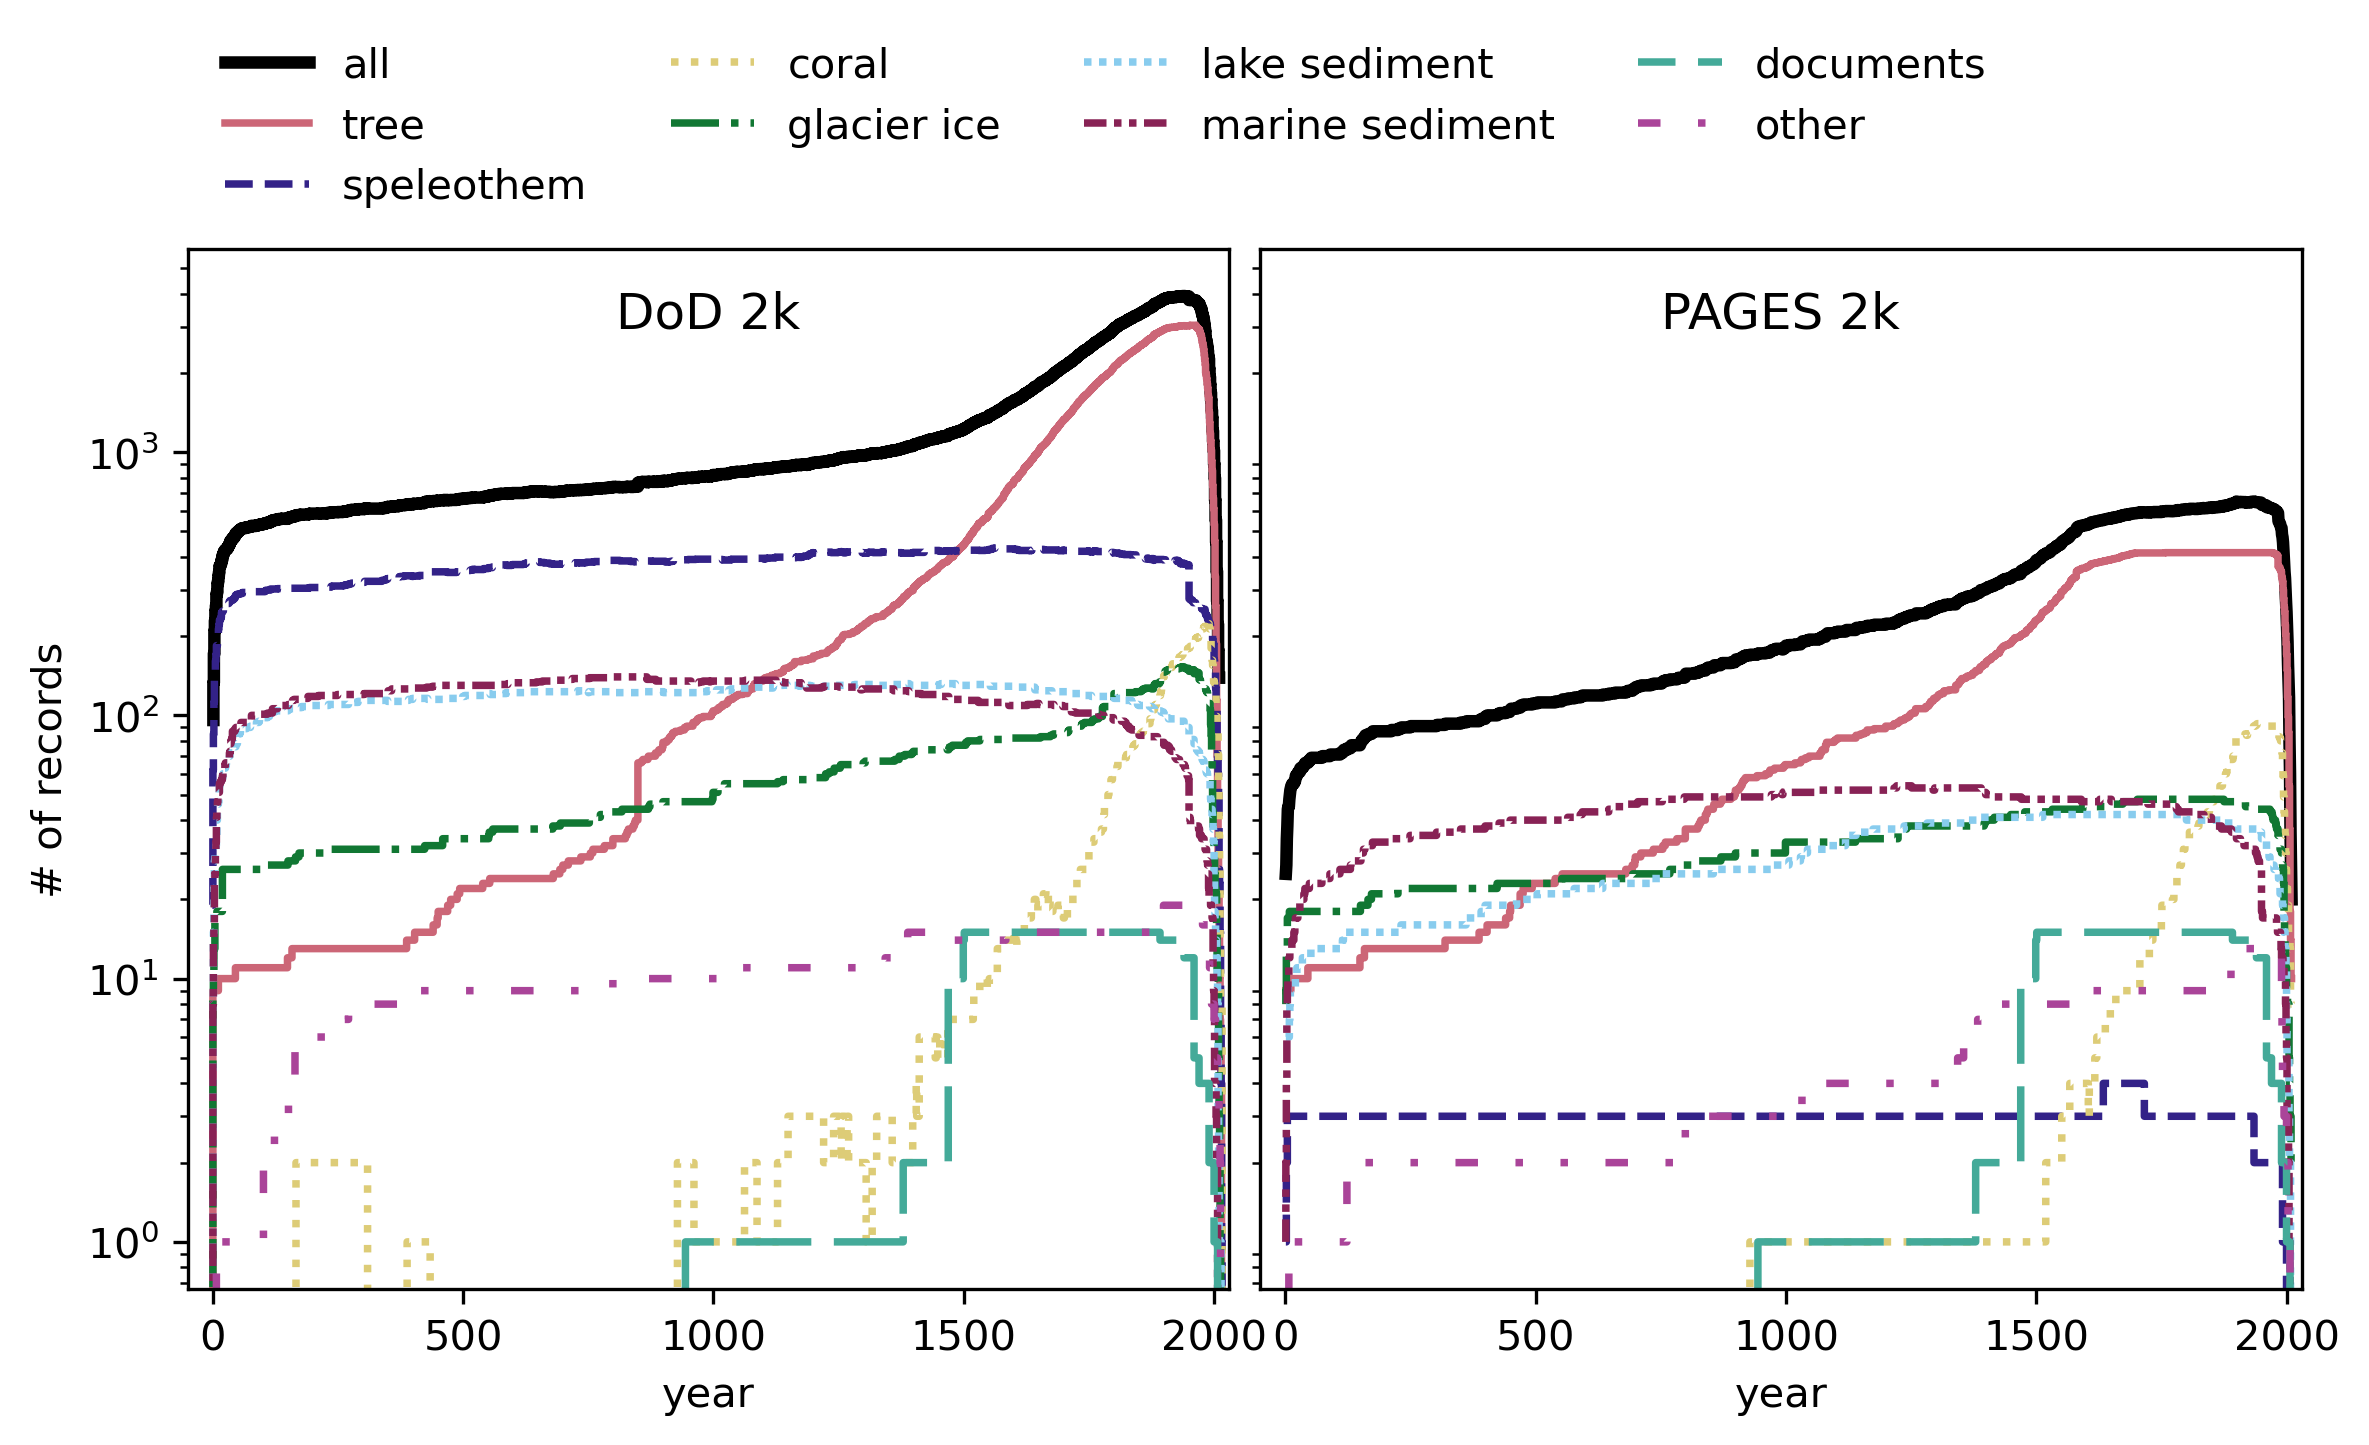

In [38]:
# plot outcome on two axis (left: total records, right: coverage per archive)
# FOR PAGES2k!!!!


ysc='log'

fig = plt.figure(figsize=(8, 5), dpi=300)
grid = GS(9,2)
ax1 = plt.subplot(grid[1:,0])
ax2 = plt.subplot(grid[1:,1])
ymask  = (years>=1)&(years<=2010)
ypmask = (years_pages>=1)&(years_pages<=2010)
ax1.step(years[ymask], coverage[ymask], color='k', label='all', lw=3)
ax2.plot(years_pages[ypmask], #coverage[ymask]-
         coverage_pages[ypmask], color='k', 
         label='all', lw=3)#, dashes=[2,1,1,1])

ax1.set_title('DoD 2k', y=0.9)
ax2.set_title('PAGES 2k', y=0.9)

for ax in [ax1, ax2]:
    ax.set_xlabel('year')
    
    ax.set_xlim(-50, 2030)
    ax.grid(False)

linestyles=['-','--',':','-.', (0, (1, 1)), (0, (3, 1, 1, 1, 1, 1)), (5, (10, 3)), (0, (3, 5, 1, 5, 1, 5))]

for ii, arch in enumerate(major_archives+['other']):
    ax1.step(years, coverage_by_archive[arch], color=archive_colour[arch],
             label=arch+'', lw=1.8, ls=linestyles[ii])
    # ax1.fill_between(years, coverage_by_archive[arch], step='pre', alpha=0.05,
    #                 color=archive_colour[arch])
    ax2.step(years_pages[ypmask], 
             # coverage_by_archive[arch][ymask]-
             coverage_by_archive_pages[arch][ypmask], 
             color=archive_colour[arch], ls=linestyles[ii],#dashes=[2,1,1,1],#ls='--',
             label=arch+'', lw=1.8)
    # ax2.fill_between(years_pages[ypmask], 
    #                  # coverage_by_archive[arch][ymask]-
    #                  coverage_by_archive_pages[arch][ypmask], 
    #                  step='pre', alpha=0.05,
    #                  color=archive_colour[arch])
    
for ax in [ax1, ax2]:
    ax.set_yscale(ysc)

ax1.set_ylabel('# of records')
ax2.yaxis.set_ticks([])



yl = ax1.get_ylim()
ax2.set_ylim(yl)


grid.tight_layout(fig)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
l_ax = plt.subplot(grid[0,:])
l_ax.legend(h1,l1, ncol=4, framealpha=0, bbox_to_anchor=(0,0), loc='lower left' )
l_ax.set_axis_off()

# l_ax = plt.subplot(grid[0,:])
# l_ax.legend(h2,l2, ncol=2, framealpha=0, bbox_to_anchor=(0,0), loc='lower left' )

# l_ax.legend(h1+h2, l1+l2,#[ll.replace(' ',' ') for ll in l1],
#             ncol=3, framealpha=0, bbox_to_anchor=(0,0), loc='lower left' )
l_ax.set_axis_off()

grid.tight_layout(fig)
grid.update(hspace=0.03,wspace=0.03)

# f.figsave(fig, '%s_temporal_avail_compared_to_PAGES2k'%df.name+'_%s'%ysc.upper(), 
#           addfigs='/%s/figs/'%df.name)


## geographical coverage

['tree: MXD', 'tree: TRW', 'tree: d18O']
['speleothem: Mg/Ca', 'speleothem: d13C', 'speleothem: d18O', 'speleothem: growth rate']
['coral: Sr/Ca', 'coral: d18O', 'other coral']
['glacier ice: d18O', 'glacier ice: d2H', 'other glacier ice']
['lake sediment: d18O', 'lake sediment: d2H', 'lake sediment: pollen', 'other lake sediment']
['marine sediment: alkenone', 'marine sediment: d18O', 'marine sediment: foram Mg/Ca', 'other marine sediment']
['documents: historic', 'other documents']
['other sclerosponge']
['other ground ice']
['other borehole']
['other mollusk shells']
['other terrestrial sediment']
['other bivalve']
['other hybrid']
saved figure in /dod2k_dupfree_dupfree/figs///dod2k_dupfree_dupfree_spatial_short.pdf


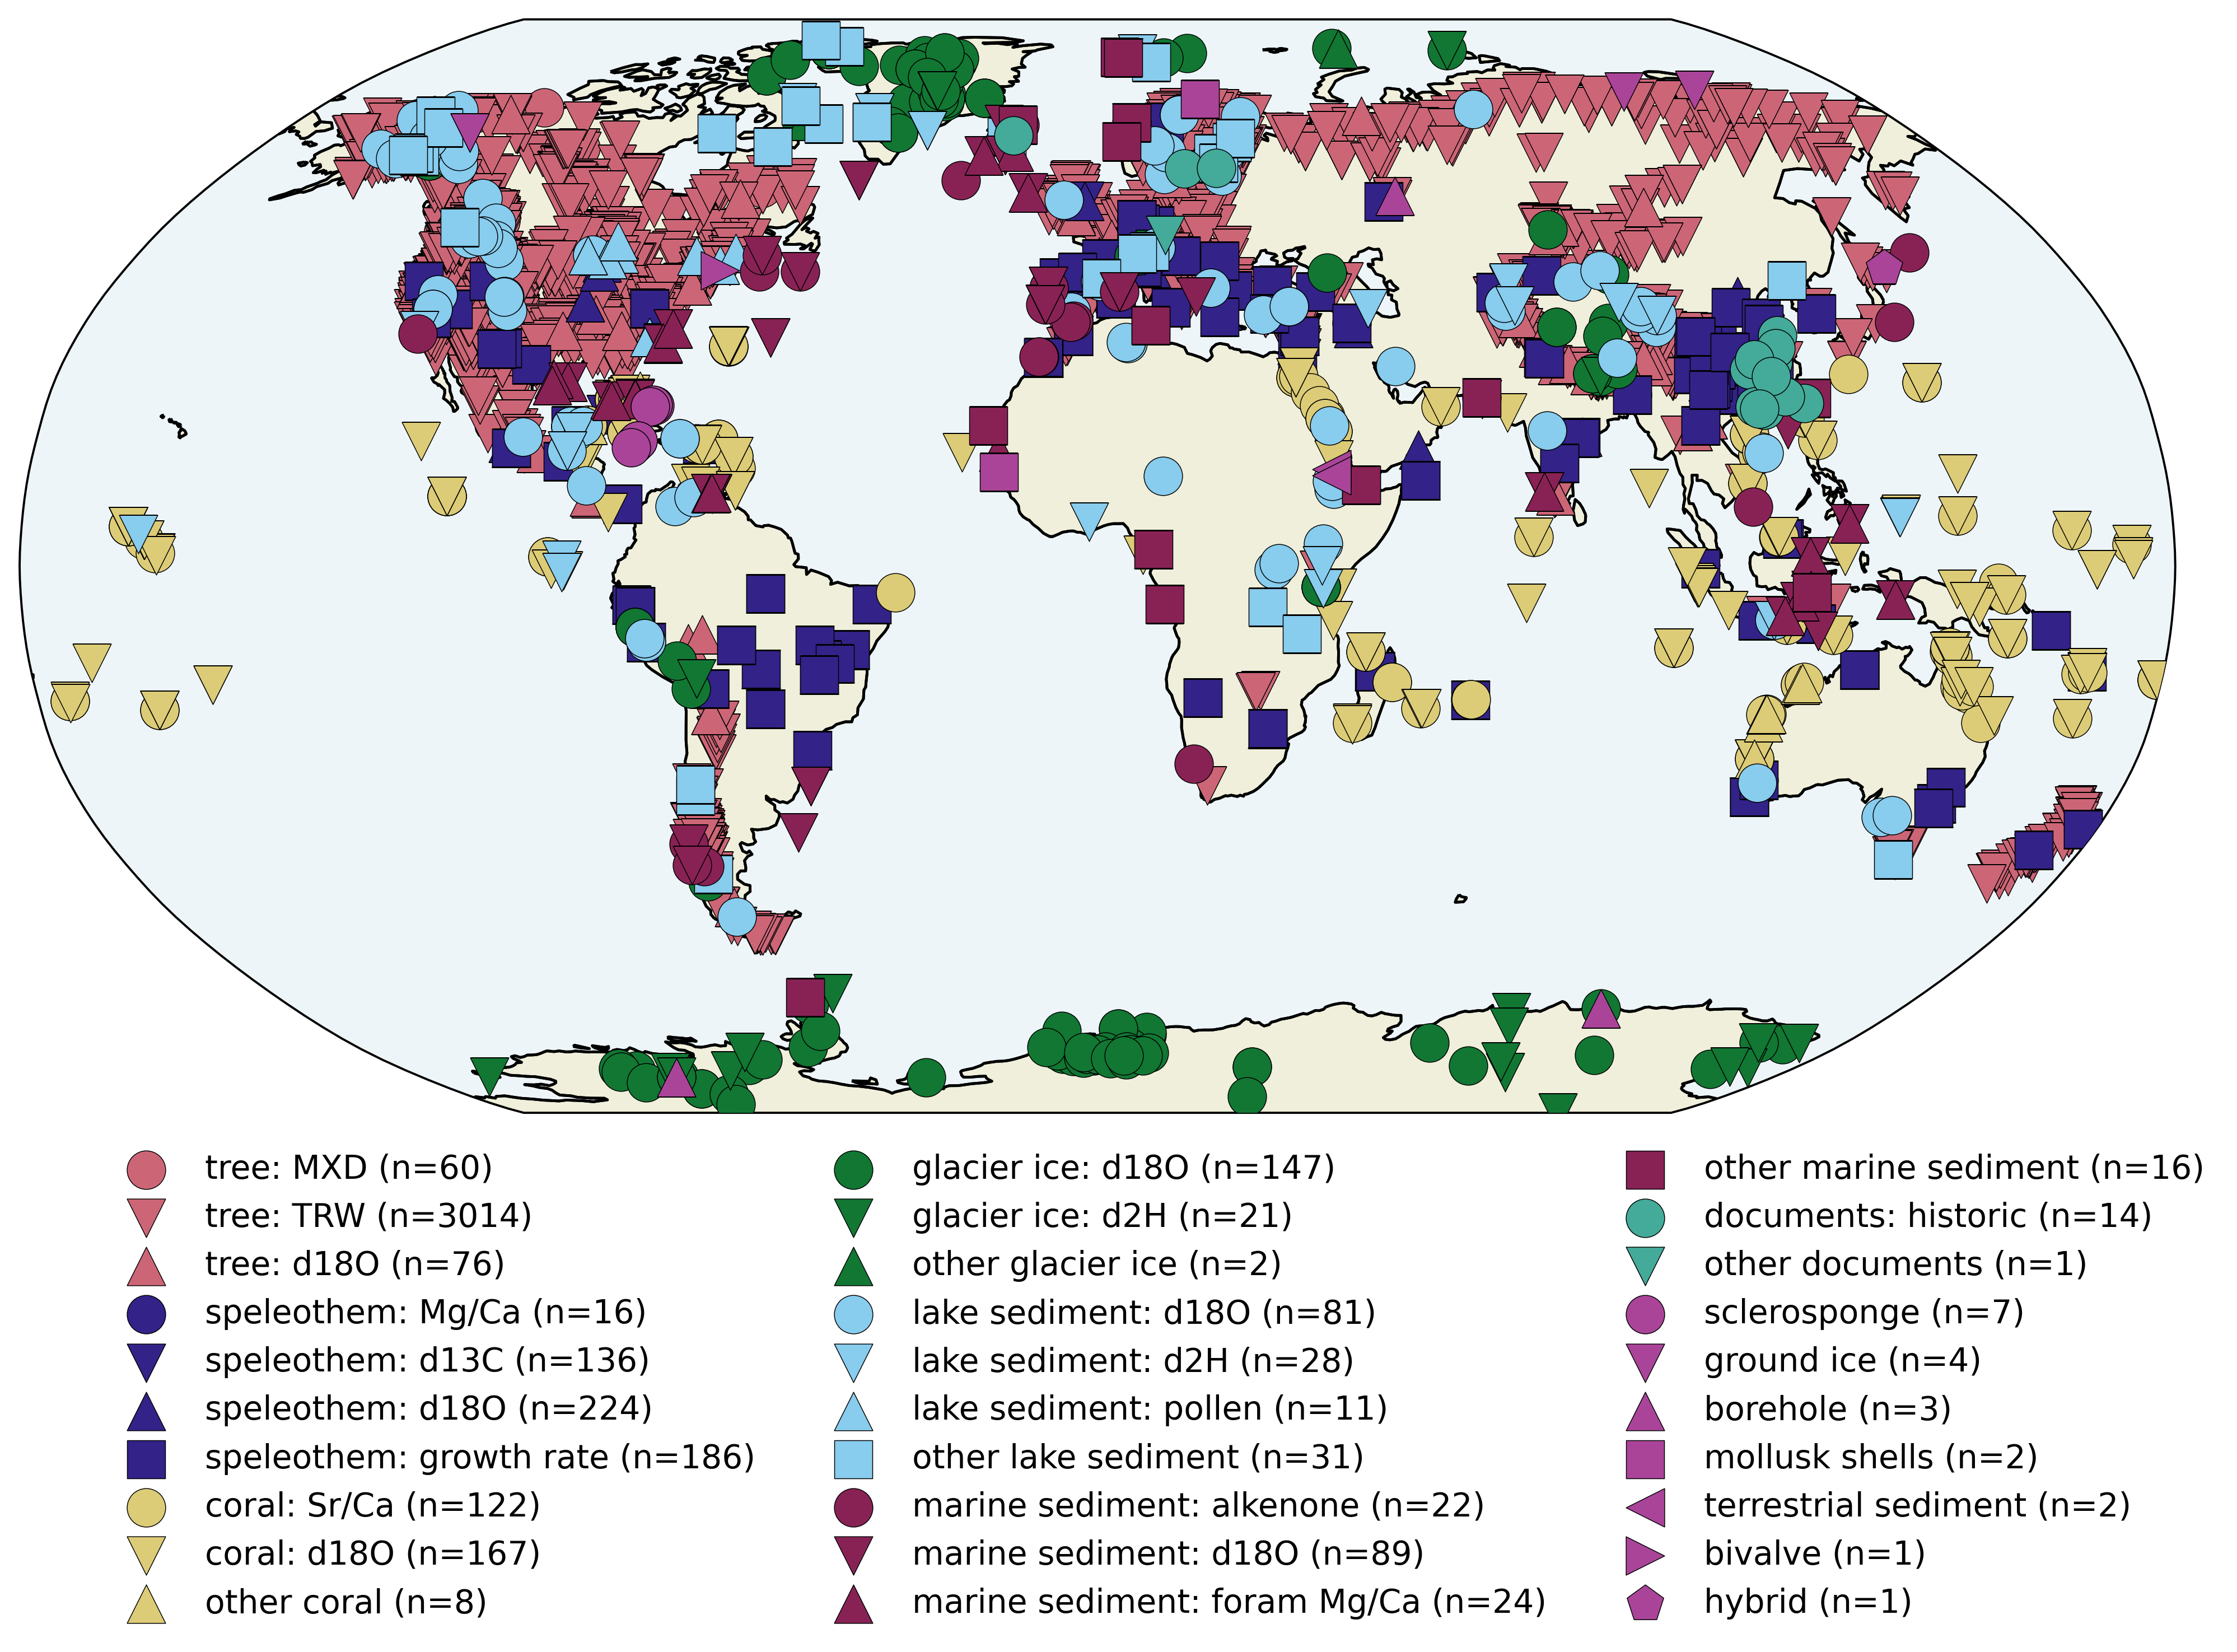

In [30]:
#%% plot the spatial distribution of all records
proxy_lats = df['geo_meanLat'].values
proxy_lons = df['geo_meanLon'].values

# plots the map
fig = plt.figure(figsize=(13, 8), dpi=350)
grid = GS(1, 3)

ax = plt.subplot(grid[:, :], projection=ccrs.Robinson()) # create axis with Robinson projection of globe
# ax.stock_img()


ax.add_feature(cfeature.LAND, alpha=0.5) # adds land features
ax.add_feature(cfeature.OCEAN, alpha=0.3, facecolor='#C5DEEA') # adds ocean features
ax.coastlines() # adds coastline features

ax.set_global()

ax.add_feature(cfeature.LAND) # adds land features
ax.coastlines() # adds coastline features

mt = 'ov^s<>pP*XDdh'*10 # generates string of marker types
archive_types = major_archives+other_archives

ijk=0
for at in archives_sorted:
    print(sorted(archive_proxy_count_short[at]))
    for ii, key in enumerate(sorted(archive_proxy_count_short[at])):
        marker = mt[ii]
        if 'other' not in key: 
            at, pt = key.split(': ')
            at_mask = df['archiveType']==at
            pt_mask = df['paleoData_proxy']==pt
            label = key+' (n=%d)'%archive_proxy_count_short[at][key]
        else:
            at= key.split('other ')[-1]
            exclude_types = [kk.split(': ')[-1] for kk in archive_proxy_count_short[at].keys() if at in kk if 'other' not in kk]
            at_mask = df['archiveType']==at
            pt_mask = ~np.isin(df['paleoData_proxy'], exclude_types)
            label = key+' (n=%d)'%df['paleoData_proxy'][pt_mask&at_mask].count()
            if exclude_types==[]:
                marker=mt[ijk]
                ijk+=1
                label = label.replace('other ','')
        plt.scatter(proxy_lons[pt_mask&at_mask], proxy_lats[pt_mask&at_mask], 
                    transform=ccrs.PlateCarree(), zorder=999,
                    marker=marker, 
                    color=archive_colour[at], 
                    label=label,
                    lw=.3, ec='k', s=200)
    
plt.legend(bbox_to_anchor=(0.03,-0.01), loc='upper left', ncol=3, fontsize=12, framealpha=0)
grid.tight_layout(fig)

f.figsave(fig, '%s_spatial_short'%df.name, addfigs='/%s/figs/'%df.name)


In [31]:
raise Exception

Exception: 

In [ ]:
#%% plot the spatial distribution of all records
proxy_lats = df['geo_meanLat'].values
proxy_lons = df['geo_meanLon'].values

# plots the map
fig = plt.figure(figsize=(15, 12), dpi=350)
grid = GS(1, 3)

ax = plt.subplot(grid[:, :], projection=ccrs.Robinson()) # create axis with Robinson projection of globe
ax.stock_img()
ax.add_feature(cfeature.LAND) # adds land features
ax.coastlines() # adds coastline features


# loop through the data to generate a scatter plot of each data record:
# 1st loop: go through archive types individually (determines marker type)
# 2nd loop: through paleo proxy types attributed to the specific archive, which is colour coded


mt = 'ov^s<>pP*XDdh'*10 # generates string of marker types

archive_types = major_archives+other_archives
# archive_types = [aa for aa in archive_types if aa!='other']


ijk=0
for jj, at in enumerate(archive_types):
    arch_mask = df['archiveType']==at
    arch_proxy_types = np.unique(df['paleoData_proxy'][arch_mask])
    for ii, pt in enumerate(arch_proxy_types):
        pt_mask = df['paleoData_proxy']==pt
        at_mask = df['archiveType']==at
        label = at+': '+pt+' ($n=%d$)'% df['paleoData_proxy'][(df['paleoData_proxy']==pt)&(df['archiveType']==at)].count()
        marker = mt[ii] if at in major_archives else mt[ijk]
        plt.scatter(proxy_lons[pt_mask&at_mask], proxy_lats[pt_mask&at_mask], 
                    transform=ccrs.PlateCarree(), zorder=999,
                    marker=marker, color=archive_colour[at], 
                    # label=label.replace('(', '\n('), 
                    label=label,#.replace('marine sediment:', 'marine sediment:\n'), 
                    lw=.3, ec='k', s=100)
        if at not in major_archives: ijk+=1
        # print(at, archive_colour[at])

    
plt.legend(bbox_to_anchor=(0.03,-0.01), loc='upper left', ncol=3, fontsize=12, framealpha=0)
grid.tight_layout(fig)

f.figsave(fig, '%s_spatial_2'%df.name, addfigs='/%s/figs/'%df.name)


## climate interpretation 

In [ ]:
[ci for ci in set(df['climateInterpretation_variable']) if ci not in ['N/A', 'nan']]

In [ ]:
#%% plot the spatial distribution of all records
proxy_lats = df['geo_meanLat'].values
proxy_lons = df['geo_meanLon'].values

# plots the map
fig = plt.figure(figsize=(8, 6), dpi=350)
grid = GS(1, 3)

ax = plt.subplot(grid[:, :], projection=ccrs.Robinson()) # create axis with Robinson projection of globe
ax.stock_img()
ax.add_feature(cfeature.LAND) # adds land features
ax.coastlines() # adds coastline features

mt = 'sDo^s<>pP*XDdh'*10 # generates string of marker types
colors  = ['tab:brown', 
           'tab:blue', 'tab:orange', 'tab:grey']

for jj, ci in enumerate([ci for ci in set(df['climateInterpretation_variable']) if ci!='N/A']):
    ci_mask = df['climateInterpretation_variable']==ci
    plt.scatter(proxy_lons[ci_mask], proxy_lats[ci_mask], 
                transform=ccrs.PlateCarree(), zorder=999,
                marker=mt[jj], color=colors[jj], 
                label=ci, lw=.3, ec='k', s=70)
plt.legend(bbox_to_anchor=(0.03,-0.01), loc='upper left', ncol=2, 
           fontsize=12, framealpha=0)
grid.tight_layout(fig)

f.figsave(fig, '%s_spatial_climateInterpretation_1'%df.name, addfigs='/%s/figs/'%df.name)


In [ ]:
#%% plot the spatial distribution of all records
proxy_lats = df['geo_meanLat'].values
proxy_lons = df['geo_meanLon'].values

# plots the map
fig = plt.figure(figsize=(8, 6), dpi=350)
grid = GS(2, 2)


mt = 'sDo^s<>pP*XDdh'*10 # generates string of marker types
colors  = ['tab:brown', 
           'tab:blue', 'tab:orange', 'tab:grey']

xi=0
yi=0
for jj, ci in enumerate([ci for ci in set(df['climateInterpretation_variable']) if ci!='N/A']):
    ax = plt.subplot(grid[xi, yi], projection=ccrs.Robinson()) # create axis with Robinson projection of globe
    ax.stock_img()
    ax.add_feature(cfeature.LAND) # adds land features
    ax.coastlines() # adds coastline features

    ci_mask = df['climateInterpretation_variable']==ci
    label = ci
    plt.scatter(proxy_lons[ci_mask], proxy_lats[ci_mask], 
                transform=ccrs.PlateCarree(), zorder=999,
                marker=mt[jj], color=colors[jj], 
                label=label,
                lw=.3, ec='k', s=70)
    # if jj==0:
    plt.legend(bbox_to_anchor=(0.03,1.01), loc='lower left', ncol=3, 
               fontsize=12, framealpha=0)
    xi+=1
    if xi==2:
        yi+=1
        xi=0
grid.tight_layout(fig)

f.figsave(fig, '%s_spatial_climateInterpretation_panels'%df.name, addfigs='/%s/figs/'%df.name)


## data 

In [ ]:
fig = plt.figure(figsize=(15, len(archive_types)*3), dpi=200)
grid = GS(len(archive_types), 1)

# loop through the data to generate a scatter plot of each data record:
# 1st loop: go through archive types individually (determines marker type)
# 2nd loop: through paleo proxy types attributed to the specific archive, which is colour coded
for jj, at in enumerate(archive_types):
    ax = plt.subplot(grid[jj, :])
    arch_mask = df['archiveType']==at
    arch_proxy_types = np.unique(df['paleoData_proxy'][arch_mask])
    col = f.get_colours(range(len(arch_proxy_types)), 'tab10', 0, len(arch_proxy_types))
    for ii, pt in enumerate(arch_proxy_types):
        pt_mask = df['paleoData_proxy']==pt
        at_mask = df['archiveType']==at
        df_slice = df[(df['paleoData_proxy']==pt)&(df['archiveType']==at)]
        for ijk in range(df_slice.shape[0]):
            label=pt if ijk==0 else None
            x = np.array(df_slice.iloc[ijk]['year'], dtype=float)
            sort = np.argsort(x)
            y = np.array(df_slice.iloc[ijk]['paleoData_values'], dtype=float)
            ax.plot(x[sort], y[sort],  lw=.5, alpha=.8, label=label, color=col[ii])
        ax.set_xlabel('year (%s)'%df_slice.iloc[0]['yearUnits'])
        ax.set_ylabel(at+'\n (%s)'%df_slice.iloc[0]['paleoData_units'])
    ax.legend(ncol=3)
grid.tight_layout(fig)

f.figsave(fig, '%s_data'%df.name, addfigs='/%s/figs/'%df.name)


In [ ]:
fig = plt.figure(figsize=(15, 5), dpi=200)
#grid = GS(len(archive_types), 1)

# loop through the data to generate a scatter plot of each data record:
# 1st loop: go through archive types individually (determines marker type)
# 2nd loop: through paleo proxy types attributed to the specific archive, which is colour coded
x0, x1 = 0, 2020
ax   = plt.gca()
ax2  = ax.twinx()
for jj, at in enumerate(archive_types):
    arch_mask = df['archiveType']==at
    arch_proxy_types = np.unique(df['paleoData_proxy'][arch_mask])
    col = f.get_colours(range(len(arch_proxy_types)), 'tab10', 0, len(arch_proxy_types))
    for ii, pt in enumerate(arch_proxy_types):
        pt_mask = df['paleoData_proxy']==pt
        at_mask = df['archiveType']==at
        df_slice = df[(df['paleoData_proxy']==pt)&(df['archiveType']==at)]
        for ijk in range(df_slice.shape[0]):
            label=at if ((ijk==0)&(ii==0)) else None
            x = np.array(df_slice.iloc[ijk]['year'], dtype=float)
            sort = np.argsort(x)
            x = x[sort]
            y = np.array(df_slice.iloc[ijk]['paleoData_values'], dtype=float)
            y = y[sort]
            mask = ((x>x0)&(x<=x1))
            y -= np.mean(y[mask])
            y /= np.std(y[mask])
            # ax = ax1 if ~np.any(y<-5000) else ax2
            ax.plot(x[mask], y[mask], lw=.5, 
                     alpha=.5, label=label, color=archive_colour[at])
        ax.set_xlabel('year (%s)'%df_slice.iloc[0]['yearUnits'])
        ax.set_ylabel('z-scores')
    leg = ax.legend(ncol=7, bbox_to_anchor=(0,1), loc='lower left')
    for line in leg.get_lines():
        line.set_lw(2)
    # ax.set_xlim(0,2020)
    #ax.set_ylim(-1000,2000)
#grid.tight_layout(fig)
ax2.plot(years[(years>=x0)&(years<=x1)], coverage[(years>=x0)&(years<=x1)], lw=2, color='k')
ax2.set_ylabel('coverage (# records)')
f.figsave(fig, '%s_data_z-scores'%df.name, addfigs='/%s/figs/'%df.name)
plt.show()

In [ ]:
# count archive types by originalDatabase (added by MNE 2025/01/07) for M and MT climateInterpretation (MNE 2025/01/21)
df = df.loc[(df['climateInterpretation_variable']=='M')|(df['climateInterpretation_variable']=='MT')]
originalDatabase_count = {}
for ii, at in enumerate(set(df['originalDatabase'])):
    originalDatabase_count[at] = df.loc[df['originalDatabase']==at, 'paleoData_proxy'].count()
    print(ii, at, originalDatabase_count[at])